# Мастерская 2. Мэтчинг товаров

Исходные данные проекта:

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу

Задача проекта:

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5

План выполнения проекта:

- загрузка необходимых библиотек, исходных файлов, задание параметров исследования
- исследовательский анализ данных
- проверка гипотез для предобработки файлов на базовых моделях библиотеки FAISS
- настройка гиперпараметров базовых моделей FAISS
- проверка наилучшей модели на тестовой выборке

## Загрузка библиотек и исходных файлов

In [1]:
#!pip install faiss-cpu

In [2]:
#!pip install --upgrade scikit-learn

In [3]:
#!pip install threadpoolctl==3.2.0

In [4]:
#!pip install --upgrade numpy

Импортируем необходимые библиотеки.

In [5]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from time import perf_counter


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
from scipy.stats import shapiro

/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/nikitagoroshevskiy/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Задаём параметры исследования.

In [6]:
K = 5 #количество ближайших соседей

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from warnings import simplefilter
simplefilter(action='ignore', category=Warning)

Загружаем датафреймы.

In [7]:
df_base = pd.read_csv('/Users/nikitagoroshevskiy/desktop/projects/data/base.csv', index_col=0)
df_train = pd.read_csv('/Users/nikitagoroshevskiy/desktop/projects/data/train.csv', index_col=0)
df_validation = pd.read_csv('/Users/nikitagoroshevskiy/desktop/projects/data/validation.csv', index_col=0)
df_validation_answer = pd.read_csv('/Users/nikitagoroshevskiy/desktop/projects/data/validation_answer.csv', index_col=0)

In [8]:
display(df_base.head())

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9         10          11  \
Id                                                                             
0-base -469.070588  44.348083  120.915344  181.449700 -124.06151  -32.458237   
1-base  -85.076666 -35.637436  119.718636  195.234190 -141.30435 -126.768900   
2-base   52.554795  62.381706  128.951450  164.381470 -140.82245  -22.486748   
3-base -383.182845 -33.611237  122.031910  136.233580 -108.47044 -104.537780   
4-base -397.711282  45.182500  122.167180  112.119064 -110.34245  -38.982060   

               12         13         14         15         16          17  \
Id                                                                          
0-base -57.420560  36.207405  182.71677 -28.071688  -5.209374   -1.732182   
1-base -68.853530   8.314717  143.08174   8.778257  15.157185   48.246360   
2-base -51.666990   2.521726  140.58545 -22.039230  -7.128634   -5.184787   
3-base -82.388490 -79.986740  113.59631 -38.995880  -4.787360    8.327808   
4-base -50.228867 -26.690920  135.27290  -7.510103   8.924209  111.576950   

               18        19          20           21          22         23  \
Id                                                                            
0-base  -91.09186 -79.46667 -103.939090  1507.231274  -32.591667  51.414360   
1-base -244.95486 -80.27942  -81.788040   429.880035   -5.937690  70.142654   
2-base -111.71212 -79.02927  -82.452576  1507.231274   -0.421011  84.108010   
3-base -124.85576 -79.10902 -107.943275  1479.170530 -125.271614  24.656485   
4-base -130.83319 -79.31585  -57.843952  1262.919738   19.225910  59.811813   

               24          25          26         27          28         29  \
Id                                                                            
0-base -51.905360  813.770071  -41.556538   8.419807 -129.976640  148.76503   
1-base  66.576840  813.770071    3.214371  17.164303  -39.418385  148.15588   
2-base  63.344510  813.770071 -105.211050  18.844700  -94.789474  151.38771   
3-base -16.921055  813.770071 -182.680270  14.715704  -62.932700  151.20198   
4-base  76.159670  312.698903  -76.726974  21.299923  -24.069107  167.38553   

               30         31          32          33         34          35  \
Id                                                                            
0-base -10.069234 -143.00504   79.848694 -537.183707   2.773180  111.518680   
1-base  -7.579590 -174.36995  101.224630 -303.939233  16.914630   53.394676   
2-base -21.483440 -144.84537   48.502934 -780.449185  64.767310   79.781555   
3-base  10.613454 -134.93434   58.777730 -529.295053  43.665924   92.806305   
4-base -44.059470 -148.13185   98.042610 -657.524388  96.363170   71.061520   

               36         37         38         39         40         41  \
Id                                                                         
0-base   4.257666 -153.34058 -123.62608 -39.707664 -12.768708  -4.170106   
1-base  33.451824 -148.55263 -110.34017 -33.277206  -8.688703  13.650302   
2-base -13.390142 -150.06166 -118.75855 -40.896286 -15.222620  -1.860338   
3-base -38.936657 -145.04530 -124.29577 -36.876730 -17.742870  10.536242   
4-base -36.563557 -135.37244 -123.70898 -44.739437 -10.855220   8.354800   

                42          43         44          45          46         47  \
Id                                                                             
0-base 

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9         10          11  \
Id                                                                             
0-base -469.070588  44.348083  120.915344  181.449700 -124.06151  -32.458237   
1-base  -85.076666 -35.637436  119.718636  195.234190 -141.30435 -126.768900   
2-base   52.554795  62.381706  128.951450  164.381470 -140.82245  -22.486748   
3-base -383.182845 -33.611237  122.031910  136.233580 -108.47044 -104.537780   
4-base -397.711282  45.182500  122.167180  112.119064 -110.34245  -38.982060   

               12         13         14         15         16          17  \
Id                                                                          
0-base -57.420560  36.207405  182.71677 -28.071688  -5.209374   -1.732182   
1-base -68.853530   8.314717  143.08174   8.778257  15.157185   48.246360   
2-base -51.666990   2.521726  140.58545 -22.039230  -7.128634   -5.184787   
3-base -82.388490 -79.986740  113.59631 -38.995880  -4.787360    8.327808   
4-base -50.228867 -26.690920  135.27290  -7.510103   8.924209  111.576950   

               18        19          20           21          22         23  \
Id                                                                            
0-base  -91.09186 -79.46667 -103.939090  1507.231274  -32.591667  51.414360   
1-base -244.95486 -80.27942  -81.788040   429.880035   -5.937690  70.142654   
2-base -111.71212 -79.02927  -82.452576  1507.231274   -0.421011  84.108010   
3-base -124.85576 -79.10902 -107.943275  1479.170530 -125.271614  24.656485   
4-base -130.83319 -79.31585  -57.843952  1262.919738   19.225910  59.811813   

               24          25          26         27          28         29  \
Id                                                                            
0-base -51.905360  813.770071  -41.556538   8.419807 -129.976640  148.76503   
1-base  66.576840  813.770071    3.214371  17.164303  -39.418385  148.15588   
2-base  63.344510  813.770071 -105.211050  18.844700  -94.789474  151.38771   
3-base -16.921055  813.770071 -182.680270  14.715704  -62.932700  151.20198   
4-base  76.159670  312.698903  -76.726974  21.299923  -24.069107  167.38553   

               30         31          32          33         34          35  \
Id                                                                            
0-base -10.069234 -143.00504   79.848694 -537.183707   2.773180  111.518680   
1-base  -7.579590 -174.36995  101.224630 -303.939233  16.914630   53.394676   
2-base -21.483440 -144.84537   48.502934 -780.449185  64.767310   79.781555   
3-base  10.613454 -134.93434   58.777730 -529.295053  43.665924   92.806305   
4-base -44.059470 -148.13185   98.042610 -657.524388  96.363170   71.061520   

               36         37         38         39         40         41  \
Id                                                                         
0-base   4.257666 -153.34058 -123.62608 -39.707664 -12.768708  -4.170106   
1-base  33.451824 -148.55263 -110.34017 -33.277206  -8.688703  13.650302   
2-base -13.390142 -150.06166 -118.75855 -40.896286 -15.222620  -1.860338   
3-base -38.936657 -145.04530 -124.29577 -36.876730 -17.742870  10.536242   
4-base -36.563557 -135.37244 -123.70898 -44.739437 -10.855220   8.354800   

                42          43         44          45          46         47  \
Id                                                                             
0-base 

In [9]:
display(df_train.head())

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9         10          11  \
Id                                                                              
0-query -347.360606  38.307602  109.085560   30.413513  -88.08269  -52.695540   
1-query  -94.572749 -78.433090  124.915900  140.331070 -177.60580  -84.995514   
2-query   26.943937 -30.447489  125.771164  211.607820  -86.34656  -35.666546   
3-query -775.150134  79.186520  124.003100  242.650650 -146.51707 -159.469850   
4-query -321.317964  45.984676  125.941284  103.392670 -107.15302   -8.800034   

                12         13          14         15         16          17  \
Id                                                                            
0-query -27.692442   4.872923  198.348000 -30.075249  -3.803569 -135.810610   
1-query  42.810810 -57.256332   96.792534 -19.261467   0.739535   50.619213   
2-query  16.395317 -80.802850  137.908650 -23.532760 -47.256584  -16.650242   
3-query -13.844755  -6.113928  118.939255 -44.585907   9.559358   14.435648   
4-query -50.977800  29.457338  143.389310   5.614824 -45.274760    9.643625   

                18         19        20           21         22          23  \
Id                                                                            
0-query -161.84137 -78.512180 -94.42894   898.436927 -70.140520   78.420360   
1-query -155.26703 -78.659430 -92.76149   353.157741 -34.744545   82.487110   
2-query -194.50568 -78.372925 -69.32448  1507.231274 -52.500970  -34.165775   
3-query -156.90683 -78.789320 -78.73709  1507.231274  19.957405   34.834290   
4-query  -77.55463 -79.066610 -77.92646  1507.231274  16.612400  116.284290   

                 24          25          26         27          28         29  \
Id                                                                              
0-query  108.032776  813.770071  -74.790880  12.610422 -183.821840  149.71584   
1-query  -28.450592  813.770071 -137.529630  26.595627 -136.783450  153.35791   
2-query   52.958652  813.770071  -18.021725  20.951107  -50.321780  158.76062   
3-query   -8.820732  813.770071 -125.606800  17.584084  -58.452904  141.28180   
4-query   33.754898  813.770071 -105.765335   6.523008  -19.812988  157.69392   

                30         31          32           33        34         35  \
Id                                                                            
0-query -27.042316 -133.21217  106.420746  -303.939233  48.73079  58.185707   
1-query  48.810093 -115.92215   87.464220  -222.286354  25.12415  91.887140   
2-query   0.178065 -183.06967   99.053570 -1018.469545 -51.80112  97.766770   
3-query -54.959310 -136.98854   63.880493 -1018.469545  89.22893  65.919960   
4-query -20.604088 -146.59128   78.849570  -780.449185  87.56077  73.036660   

                36         37          38         39         40        41  \
Id                                                                          
0-query  24.250950 -151.22410 -104.282265 -34.492810 -12.587054  2.622891   
1-query -30.636870 -136.59314 -140.500120 -43.449757  -7.226884  8.265747   
2-query -10.865850 -144.42316 -133.819490 -78.902300 -17.200352  4.467452   
3-query -24.078644 -152.33410  -91.199380 -28.225390  -4.767386  0.158236   
4-query  16.891030 -144.65790 -116.122150 -19.353254  -7.709266 -5.394988   

                 42         43         44          45          46         47  \
Id                                    

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9         10          11  \
Id                                                                              
0-query -347.360606  38.307602  109.085560   30.413513  -88.08269  -52.695540   
1-query  -94.572749 -78.433090  124.915900  140.331070 -177.60580  -84.995514   
2-query   26.943937 -30.447489  125.771164  211.607820  -86.34656  -35.666546   
3-query -775.150134  79.186520  124.003100  242.650650 -146.51707 -159.469850   
4-query -321.317964  45.984676  125.941284  103.392670 -107.15302   -8.800034   

                12         13          14         15         16          17  \
Id                                                                            
0-query -27.692442   4.872923  198.348000 -30.075249  -3.803569 -135.810610   
1-query  42.810810 -57.256332   96.792534 -19.261467   0.739535   50.619213   
2-query  16.395317 -80.802850  137.908650 -23.532760 -47.256584  -16.650242   
3-query -13.844755  -6.113928  118.939255 -44.585907   9.559358   14.435648   
4-query -50.977800  29.457338  143.389310   5.614824 -45.274760    9.643625   

                18         19        20           21         22          23  \
Id                                                                            
0-query -161.84137 -78.512180 -94.42894   898.436927 -70.140520   78.420360   
1-query -155.26703 -78.659430 -92.76149   353.157741 -34.744545   82.487110   
2-query -194.50568 -78.372925 -69.32448  1507.231274 -52.500970  -34.165775   
3-query -156.90683 -78.789320 -78.73709  1507.231274  19.957405   34.834290   
4-query  -77.55463 -79.066610 -77.92646  1507.231274  16.612400  116.284290   

                 24          25          26         27          28         29  \
Id                                                                              
0-query  108.032776  813.770071  -74.790880  12.610422 -183.821840  149.71584   
1-query  -28.450592  813.770071 -137.529630  26.595627 -136.783450  153.35791   
2-query   52.958652  813.770071  -18.021725  20.951107  -50.321780  158.76062   
3-query   -8.820732  813.770071 -125.606800  17.584084  -58.452904  141.28180   
4-query   33.754898  813.770071 -105.765335   6.523008  -19.812988  157.69392   

                30         31          32           33        34         35  \
Id                                                                            
0-query -27.042316 -133.21217  106.420746  -303.939233  48.73079  58.185707   
1-query  48.810093 -115.92215   87.464220  -222.286354  25.12415  91.887140   
2-query   0.178065 -183.06967   99.053570 -1018.469545 -51.80112  97.766770   
3-query -54.959310 -136.98854   63.880493 -1018.469545  89.22893  65.919960   
4-query -20.604088 -146.59128   78.849570  -780.449185  87.56077  73.036660   

                36         37          38         39         40        41  \
Id                                                                          
0-query  24.250950 -151.22410 -104.282265 -34.492810 -12.587054  2.622891   
1-query -30.636870 -136.59314 -140.500120 -43.449757  -7.226884  8.265747   
2-query -10.865850 -144.42316 -133.819490 -78.902300 -17.200352  4.467452   
3-query -24.078644 -152.33410  -91.199380 -28.225390  -4.767386  0.158236   
4-query  16.891030 -144.65790 -116.122150 -19.353254  -7.709266 -5.394988   

                 42         43         44          45          46         47  \
Id                                    

In [10]:
display(df_validation.head())

0          1          2          3          4  \
Id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   
100002-query -64.175095  -3.980927  -7.679249 -170.16093   96.44616   
100003-query -99.286860  16.123936   9.837166 -148.06044   83.69708   
100004-query -79.532920  -0.364173 -16.027431 -170.88495  165.45392   

                       5           6           7           8           9  \
Id                                                                         
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914   

                     10          11         12         13         14  \
Id                                                                     
100000-query -131.89280 -140.968570 -57.987164 -22.868887  150.89552   
100001-query -153.71725  -63.951330 -52.369495 -33.390945  148.61950   
100002-query -220.30954  -31.378445  -8.788761   2.285323  133.26611   
100003-query -114.27196  -71.406456 -65.349320  24.377070   50.46730   
100004-query  -76.21417  -26.393860  34.423640  50.938890  157.68318   

                     15         16         17         18         19  \
Id                                                                    
100000-query   7.965574  17.622066 -34.868217 -216.13855 -80.908730   
100001-query -22.483830  15.164185 -56.202000 -153.61438 -79.831825   
100002-query -41.309080  14.305538 -18.231812 -205.53370 -78.160310   
100003-query -14.721335  15.069309 -46.682995 -176.60437 -78.690700   
100004-query -23.786497 -33.175415  -0.592607 -193.31854 -79.651030   

                      20           21         22          23         24  \
Id                                                                        
100000-query  -52.579520   263.363136  56.266876   66.924710  21.609911   
100001-query -101.055480  1203.537156  81.597130  101.018654  56.783424   
100002-query  -96.607670  1507.231274  -5.964200   34.937443 -56.086887   
100003-query -139.227450   325.547112   3.632292   74.929504  -4.802103   
100004-query  -91.889786  1358.481072  44.027733  121.527210  46.183000   

                      25          26         27         28         29  \
Id                                                                      
100000-query  813.770071  -32.782940  20.794031 -79.779076  156.30708   
100001-query   92.209628 -126.860340  10.382887 -38.523360  165.38391   
100002-query  813.770071  -13.200474  18.966661 -35.110190  151.36850   
100003-query  813.770071  -52.982597  15.644381 -54.087467  151.30914   
100004-query  433.623103  -82.233200  21.068508 -32.940117  149.26895   

                     30          31          32          33          34  \
Id                                                                        
100000-query -42.831330  -71.723335   83.283660 -304.174382    1.609402   
100001-query -77.840485 -169.538680  103.483240 -915.735701   16.109938   
100002-query -17.490252 -145.884300   15.533379 -655.395514   39.412827   
100003-query  21.088570 -134.507890   65.118960 -529.295053  131.565520   
100004-query   0.404718  -97.674530   81.719990 -825.644804    9.397169   

                     35         36         37          38         39  \
Id                                                                     
100000-query  55.834587 -29.474255 -139.16277 -126.038350 -62.643830   
100001-query  14.669937 -38.707085 -149.53838 -138.792920 -36.076176   
100002-query  62.554955   9.924992 -143.93462 -123.107796 -37.032475   
100003-query  67.642700 -22.884491 -145.90652  -86.917330 -11.86

0          1          2          3          4  \
Id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   
100002-query -64.175095  -3.980927  -7.679249 -170.16093   96.44616   
100003-query -99.286860  16.123936   9.837166 -148.06044   83.69708   
100004-query -79.532920  -0.364173 -16.027431 -170.88495  165.45392   

                       5           6           7           8           9  \
Id                                                                         
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914   

                     10          11         12         13         14  \
Id                                                                     
100000-query -131.89280 -140.968570 -57.987164 -22.868887  150.89552   
100001-query -153.71725  -63.951330 -52.369495 -33.390945  148.61950   
100002-query -220.30954  -31.378445  -8.788761   2.285323  133.26611   
100003-query -114.27196  -71.406456 -65.349320  24.377070   50.46730   
100004-query  -76.21417  -26.393860  34.423640  50.938890  157.68318   

                     15         16         17         18         19  \
Id                                                                    
100000-query   7.965574  17.622066 -34.868217 -216.13855 -80.908730   
100001-query -22.483830  15.164185 -56.202000 -153.61438 -79.831825   
100002-query -41.309080  14.305538 -18.231812 -205.53370 -78.160310   
100003-query -14.721335  15.069309 -46.682995 -176.60437 -78.690700   
100004-query -23.786497 -33.175415  -0.592607 -193.31854 -79.651030   

                      20           21         22          23         24  \
Id                                                                        
100000-query  -52.579520   263.363136  56.266876   66.924710  21.609911   
100001-query -101.055480  1203.537156  81.597130  101.018654  56.783424   
100002-query  -96.607670  1507.231274  -5.964200   34.937443 -56.086887   
100003-query -139.227450   325.547112   3.632292   74.929504  -4.802103   
100004-query  -91.889786  1358.481072  44.027733  121.527210  46.183000   

                      25          26         27         28         29  \
Id                                                                      
100000-query  813.770071  -32.782940  20.794031 -79.779076  156.30708   
100001-query   92.209628 -126.860340  10.382887 -38.523360  165.38391   
100002-query  813.770071  -13.200474  18.966661 -35.110190  151.36850   
100003-query  813.770071  -52.982597  15.644381 -54.087467  151.30914   
100004-query  433.623103  -82.233200  21.068508 -32.940117  149.26895   

                     30          31          32          33          34  \
Id                                                                        
100000-query -42.831330  -71.723335   83.283660 -304.174382    1.609402   
100001-query -77.840485 -169.538680  103.483240 -915.735701   16.109938   
100002-query -17.490252 -145.884300   15.533379 -655.395514   39.412827   
100003-query  21.088570 -134.507890   65.118960 -529.295053  131.565520   
100004-query   0.404718  -97.674530   81.719990 -825.644804    9.397169   

                     35         36         37          38         39  \
Id                                                                     
100000-query  55.834587 -29.474255 -139.16277 -126.038350 -62.643830   
100001-query  14.669937 -38.707085 -149.53838 -138.792920 -36.076176   
100002-query  62.554955   9.924992 -143.93462 -123.107796 -37.032475   
100003-query  67.642700 -22.884491 -145.90652  -86.917330 -11.86

In [11]:
display(df_validation_answer.head())

Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

Expected
Id                        
100000-query  2676668-base
100001-query    91606-base
100002-query   472256-base
100003-query  3168654-base
100004-query    75484-base

## Исследовательский анализ данных

Исследовательский анализ данных мы будем проводить на двух крупнейших по иерархии выборках: df_base и df_train.

Определяем функцию для исследовательского анализа данных.

In [12]:
def eda(df):
    print('Информация о датафрейме')
    print('_'*60)
    
    print('Размерность датафрейма:', df.shape)
    print('_'*60)
    
    print('Типы данных датафрейма:')
    print(df.info())
    print('_'*60)
    
    print('Распределение данных в датафрейме:')
    display(df.describe())
    print('_'*60)
    
    print('Количество дубликатов в датафрейме:')
    print(df.duplicated().sum().sum())
    print('_'*60)
    
    print('Количество пропусков в датафрейме:')
    print(df.isna().sum().sum())
    print('_'*60)
    
    print('Гистограммы распределения по признакам:')
    fig, axis = plt.subplots(18,4,figsize=(20, 80))
    df.hist(ax=axis)
    plt.tight_layout()
    plt.show()
    print('_'*60)
    
    print('Диаграммы размахов по признакам:')
    fig, axis = plt.subplots(18,4,figsize=(20, 80))
    df.plot(
        kind='box',
        ax=axis,
        subplots=True,
        sharey=False,
        figsize=(80,20)
    )
    plt.tight_layout()
    plt.show()
    print('_'*60)
    
    print('График корреляции признаков:')
    corr = df.corr()
    sns.heatmap(corr, cmap='crest')
    plt.show()
    print('_'*60)
    
    return

Информация о датафрейме
____________________________________________________________
Размерность датафрейма: (2918139, 72)
____________________________________________________________
Типы данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 3

0             1             2             3             4  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -8.622947e+01  8.080077e+00 -4.458080e+01 -1.466350e+02  1.113166e+02   
std    2.489132e+01  4.953387e+00  3.863166e+01  1.984480e+01  4.634809e+01   
min   -1.994687e+02 -1.391461e+01 -2.400734e+02 -2.326671e+02 -1.055830e+02   
25%   -1.030654e+02  4.708491e+00 -6.955949e+01 -1.599051e+02  8.050795e+01   
50%   -8.623150e+01  8.038950e+00 -4.381661e+01 -1.467768e+02  1.118730e+02   
75%   -6.925658e+01  1.147007e+01 -1.962527e+01 -1.333277e+02  1.423743e+02   
max    2.151555e+01  2.993721e+01  1.609372e+02 -5.137478e+01  3.196645e+02   

                  5             6             7             8             9  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -7.199138e+01 -3.922239e+02  2.035283e+01  1.236842e+02  1.244581e+02   
std    2.818607e+01  2.716550e+02  6.421638e+01  6.356109e+00  6.443058e+01   
min   -2.110086e+02 -7.914699e+02 -3.018597e+02  9.315305e+01 -1.738719e+02   
25%   -9.137994e+01 -6.293318e+02 -2.222147e+01  1.194840e+02  8.176751e+01   
50%   -7.192230e+01 -4.222016e+02  2.080477e+01  1.238923e+02  1.234977e+02   
75%   -5.244111e+01 -1.566686e+02  6.391821e+01  1.279705e+02  1.672206e+02   
max    5.880624e+01  1.096325e+02  3.412282e+02  1.522612e+02  4.275421e+02   

                 10            11            12            13            14  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -1.431396e+02 -6.988662e+01 -4.126493e+01  7.587780e+00  1.489852e+02   
std    4.168737e+01  5.121991e+01  3.896358e+01  3.659725e+01  3.363559e+01   
min   -3.438436e+02 -3.684526e+02 -2.260906e+02 -1.756239e+02 -1.526698e+01   
25%   -1.703175e+02 -1.040333e+02 -6.662606e+01 -1.694393e+01  1.259664e+02   
50%   -1.417156e+02 -7.022748e+01 -4.039738e+01  8.128445e+00  1.493146e+02   
75%   -1.149862e+02 -3.569530e+01 -1.483560e+01  3.267095e+01  1.721625e+02   
max    4.140846e+01  1.824389e+02  1.207674e+02  1.775270e+02  2.917480e+02   

                 15            16            17            18            19  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -2.316701e+01 -9.366916e-01 -1.931312e+01 -1.372712e+02 -7.918932e+01   
std    1.307563e+01  2.083201e+01  5.297210e+01  4.662566e+01  7.574403e-01   
min   -8.591711e+01 -9.636816e+01 -2.725656e+02 -3.517478e+02 -8.315235e+01   
25%   -3.176832e+01 -1.515450e+01 -5.546463e+01 -1.675851e+02 -7.967751e+01   
50%   -2.291030e+01 -1.032792e+00 -1.980470e+01 -1.368043e+02 -7.917803e+01   
75%   -1.434341e+01  1.337403e+01  1.658952e+01 -1.075373e+02 -7.867896e+01   
max    4.507333e+01  1.053910e+02  2.207994e+02  9.768367e+01 -7.579646e+01   

                 20            21            22            23            24  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -9.825383e+01  1.257528e+03 -6.824936e+00  5.667382e+01  2.669563e+01   
std    2.815861e+01  3.999612e+02  5.197251e+01  3.436061e+01  3.894157e+01   
min   -2.437279e+02  1.368182e+02 -2.382874e+02 -8.818329e+01 -1.431833e+02   
25%   -1.168426e+02  1.088597e+03 -4.224413e+01  3.329542e+01  5.564670e-01   
50%   -9.752848e+01  1.507231e+03 -6.418125e+00  5.699871e+01  2.713143e+01   
75%   -7.924342e+01  1.507231e+03  2.823144e+01  7.966341e+01  5.308961e+01   
max    3.212392e+01  1.557433e+03  2.288031e+02  2.143112e+02  2.135212e+02   

                 25            26            27            28            29  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   7.271026e+02 -6.625340e+01  1.631537e+01 -8.637482e+01  1.517346e+02   
std    2.055724e+02  6.153334e+01  4.656628e+00  4.851313e+01  1.009000e+01   
min   -6.198046e+01 -3.585515e+02 -8.364693e+00 -3.140082e+02  1.074433e+02   
25%    8.137701e+02 -1.078521e+02  1.326106e+01 -1.186601e+02  

0             1             2             3             4  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -8.622947e+01  8.080077e+00 -4.458080e+01 -1.466350e+02  1.113166e+02   
std    2.489132e+01  4.953387e+00  3.863166e+01  1.984480e+01  4.634809e+01   
min   -1.994687e+02 -1.391461e+01 -2.400734e+02 -2.326671e+02 -1.055830e+02   
25%   -1.030654e+02  4.708491e+00 -6.955949e+01 -1.599051e+02  8.050795e+01   
50%   -8.623150e+01  8.038950e+00 -4.381661e+01 -1.467768e+02  1.118730e+02   
75%   -6.925658e+01  1.147007e+01 -1.962527e+01 -1.333277e+02  1.423743e+02   
max    2.151555e+01  2.993721e+01  1.609372e+02 -5.137478e+01  3.196645e+02   

                  5             6             7             8             9  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -7.199138e+01 -3.922239e+02  2.035283e+01  1.236842e+02  1.244581e+02   
std    2.818607e+01  2.716550e+02  6.421638e+01  6.356109e+00  6.443058e+01   
min   -2.110086e+02 -7.914699e+02 -3.018597e+02  9.315305e+01 -1.738719e+02   
25%   -9.137994e+01 -6.293318e+02 -2.222147e+01  1.194840e+02  8.176751e+01   
50%   -7.192230e+01 -4.222016e+02  2.080477e+01  1.238923e+02  1.234977e+02   
75%   -5.244111e+01 -1.566686e+02  6.391821e+01  1.279705e+02  1.672206e+02   
max    5.880624e+01  1.096325e+02  3.412282e+02  1.522612e+02  4.275421e+02   

                 10            11            12            13            14  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -1.431396e+02 -6.988662e+01 -4.126493e+01  7.587780e+00  1.489852e+02   
std    4.168737e+01  5.121991e+01  3.896358e+01  3.659725e+01  3.363559e+01   
min   -3.438436e+02 -3.684526e+02 -2.260906e+02 -1.756239e+02 -1.526698e+01   
25%   -1.703175e+02 -1.040333e+02 -6.662606e+01 -1.694393e+01  1.259664e+02   
50%   -1.417156e+02 -7.022748e+01 -4.039738e+01  8.128445e+00  1.493146e+02   
75%   -1.149862e+02 -3.569530e+01 -1.483560e+01  3.267095e+01  1.721625e+02   
max    4.140846e+01  1.824389e+02  1.207674e+02  1.775270e+02  2.917480e+02   

                 15            16            17            18            19  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -2.316701e+01 -9.366916e-01 -1.931312e+01 -1.372712e+02 -7.918932e+01   
std    1.307563e+01  2.083201e+01  5.297210e+01  4.662566e+01  7.574403e-01   
min   -8.591711e+01 -9.636816e+01 -2.725656e+02 -3.517478e+02 -8.315235e+01   
25%   -3.176832e+01 -1.515450e+01 -5.546463e+01 -1.675851e+02 -7.967751e+01   
50%   -2.291030e+01 -1.032792e+00 -1.980470e+01 -1.368043e+02 -7.917803e+01   
75%   -1.434341e+01  1.337403e+01  1.658952e+01 -1.075373e+02 -7.867896e+01   
max    4.507333e+01  1.053910e+02  2.207994e+02  9.768367e+01 -7.579646e+01   

                 20            21            22            23            24  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -9.825383e+01  1.257528e+03 -6.824936e+00  5.667382e+01  2.669563e+01   
std    2.815861e+01  3.999612e+02  5.197251e+01  3.436061e+01  3.894157e+01   
min   -2.437279e+02  1.368182e+02 -2.382874e+02 -8.818329e+01 -1.431833e+02   
25%   -1.168426e+02  1.088597e+03 -4.224413e+01  3.329542e+01  5.564670e-01   
50%   -9.752848e+01  1.507231e+03 -6.418125e+00  5.699871e+01  2.713143e+01   
75%   -7.924342e+01  1.507231e+03  2.823144e+01  7.966341e+01  5.308961e+01   
max    3.212392e+01  1.557433e+03  2.288031e+02  2.143112e+02  2.135212e+02   

                 25            26            27            28            29  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   7.271026e+02 -6.625340e+01  1.631537e+01 -8.637482e+01  1.517346e+02   
std    2.055724e+02  6.153334e+01  4.656628e+00  4.851313e+01  1.009000e+01   
min   -6.198046e+01 -3.585515e+02 -8.364693e+00 -3.140082e+02  1.074433e+02   
25%    8.137701e+02 -1.078521e+02  1.326106e+01 -1.186601e+02  

____________________________________________________________
Количество дубликатов в датафрейме:
____________________________________________________________
Количество дубликатов в датафрейме:
0
____________________________________________________________
Количество пропусков в датафрейме:
0
____________________________________________________________
Количество пропусков в датафрейме:
0
____________________________________________________________
Гистограммы распределения по признакам:
0
____________________________________________________________
Гистограммы распределения по признакам:


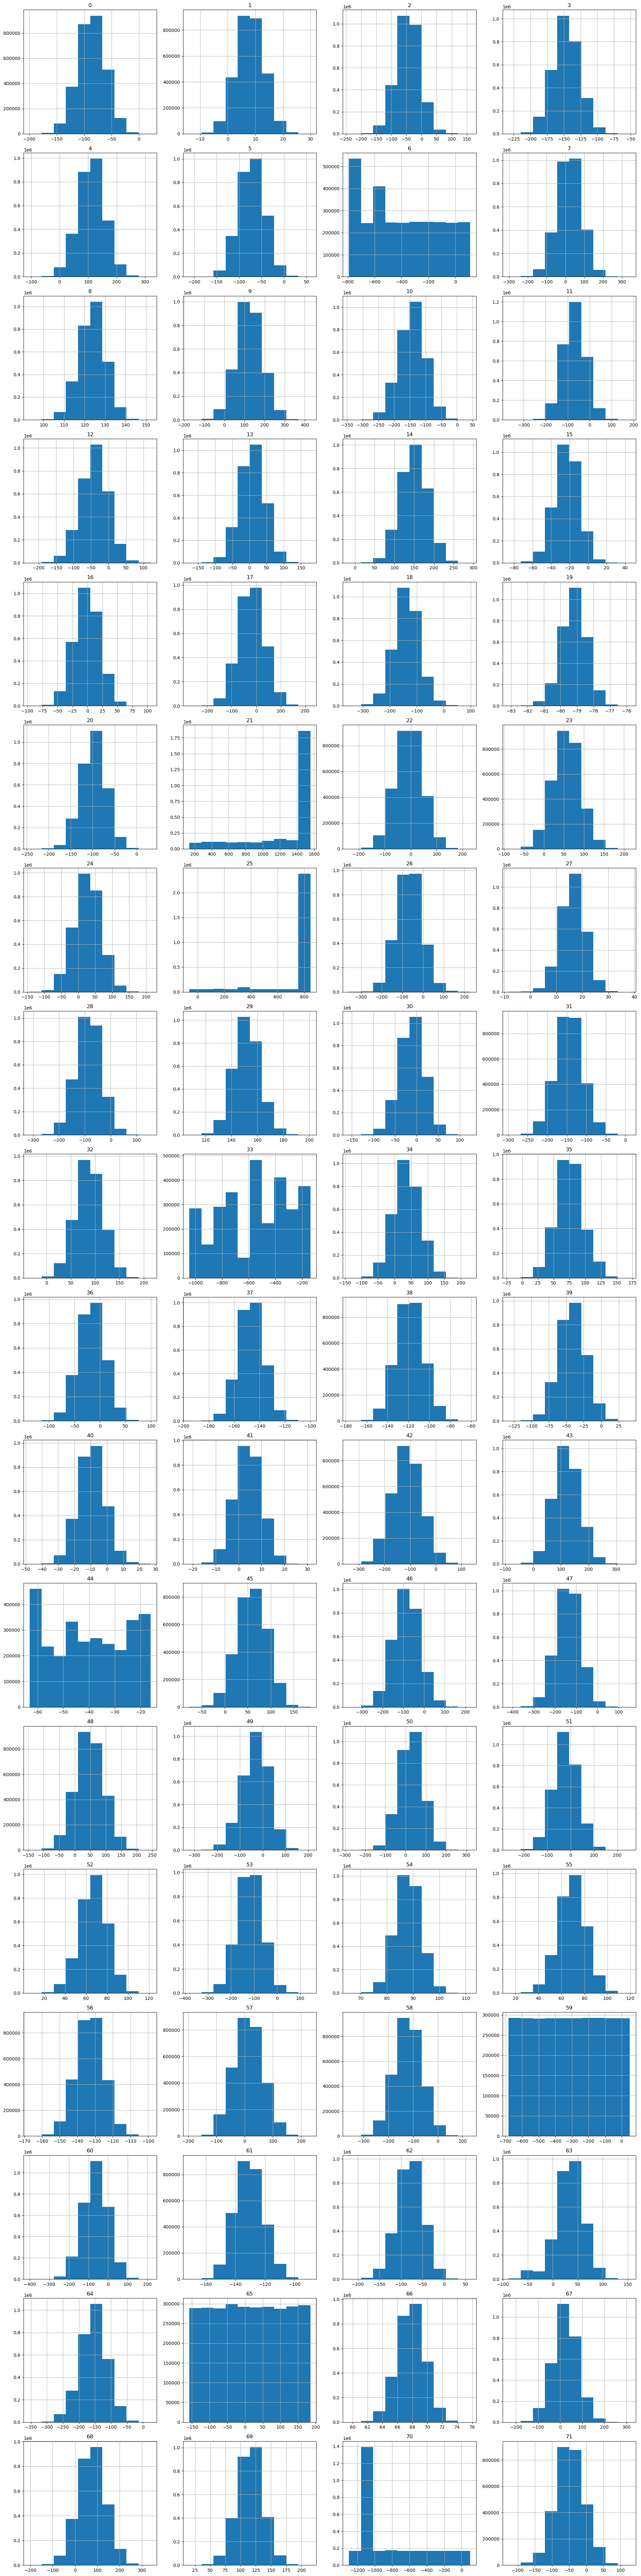

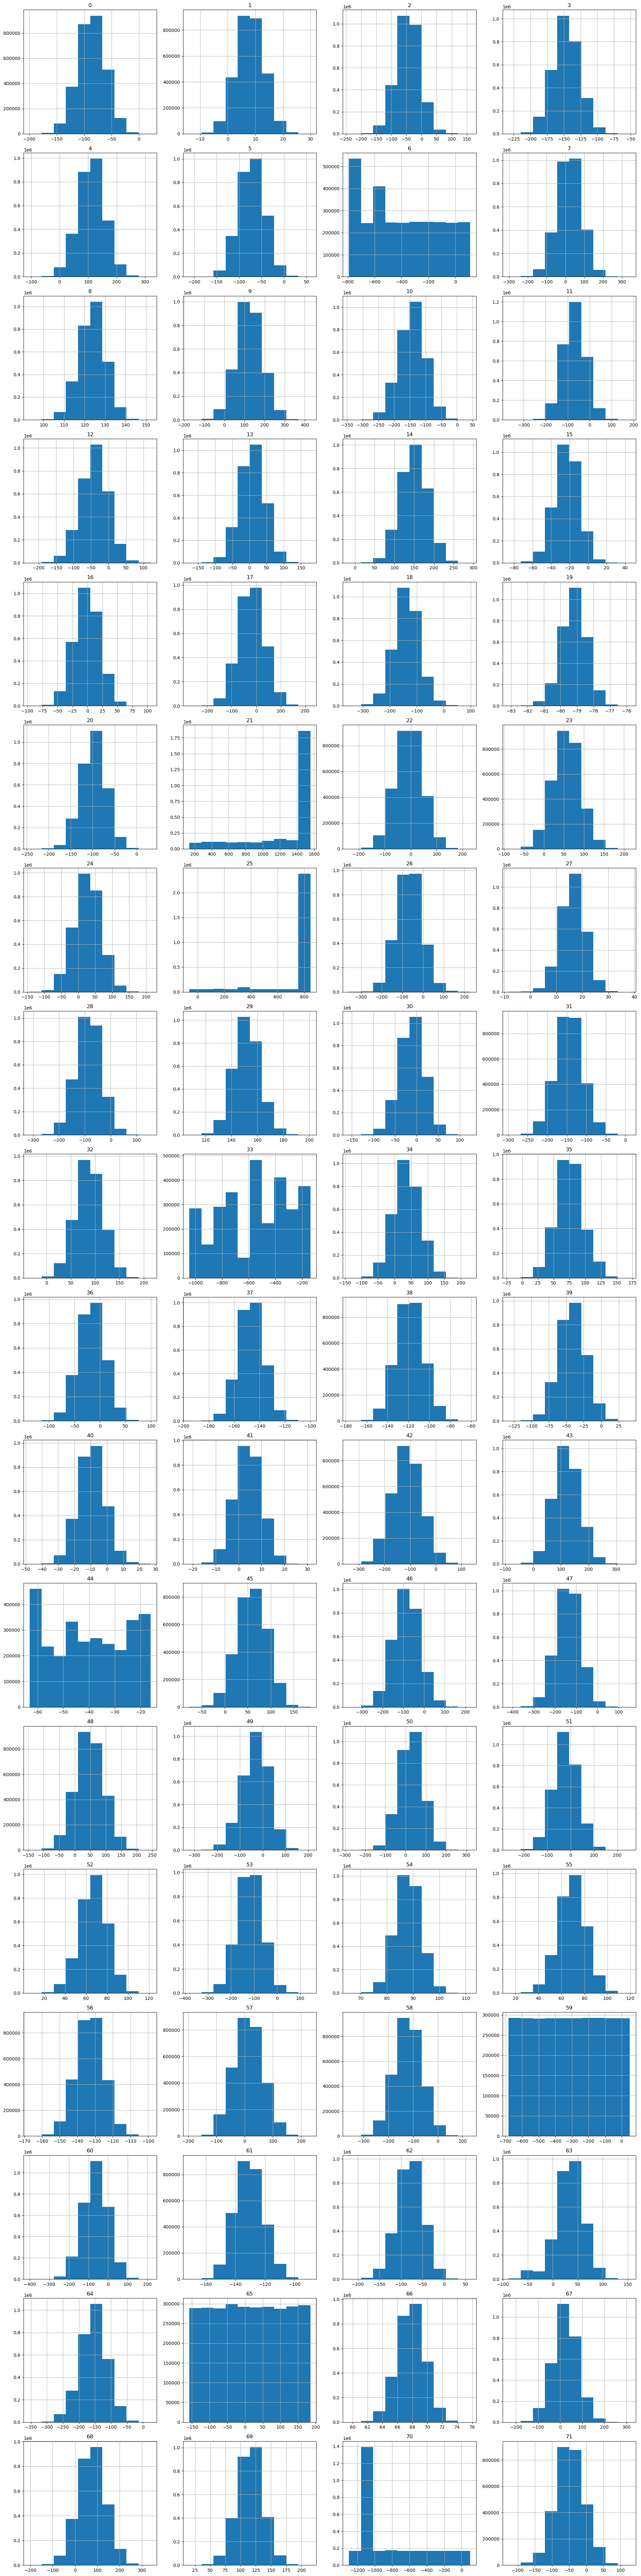

____________________________________________________________
Диаграммы размахов по признакам:
____________________________________________________________
Диаграммы размахов по признакам:


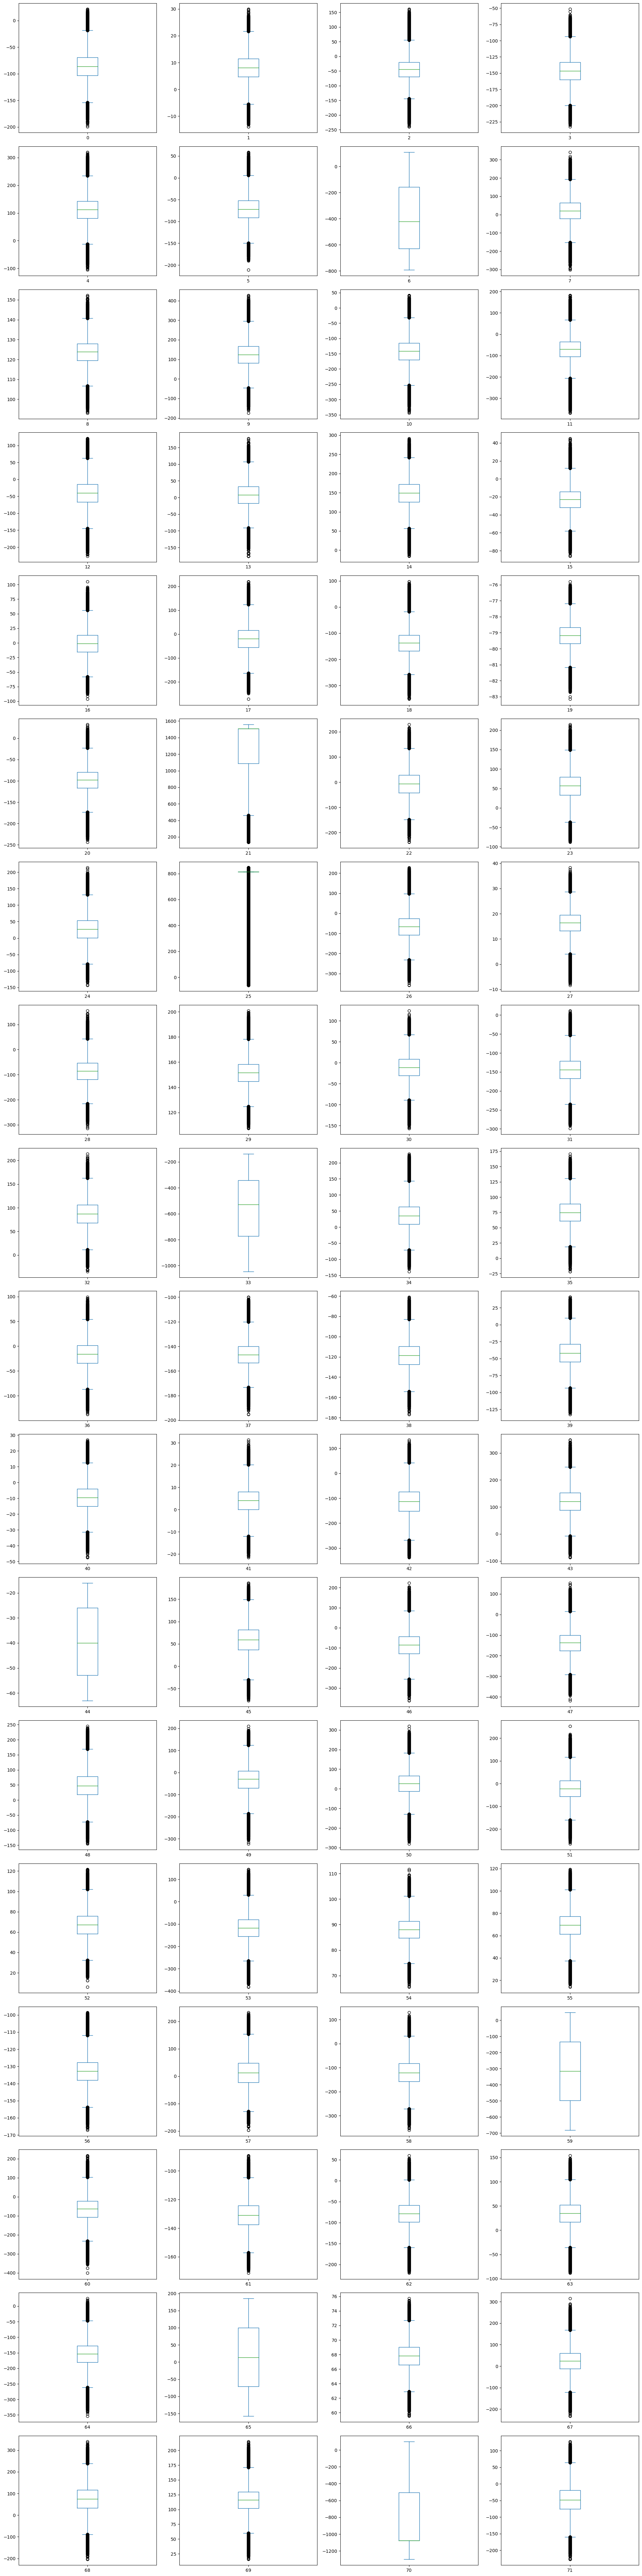

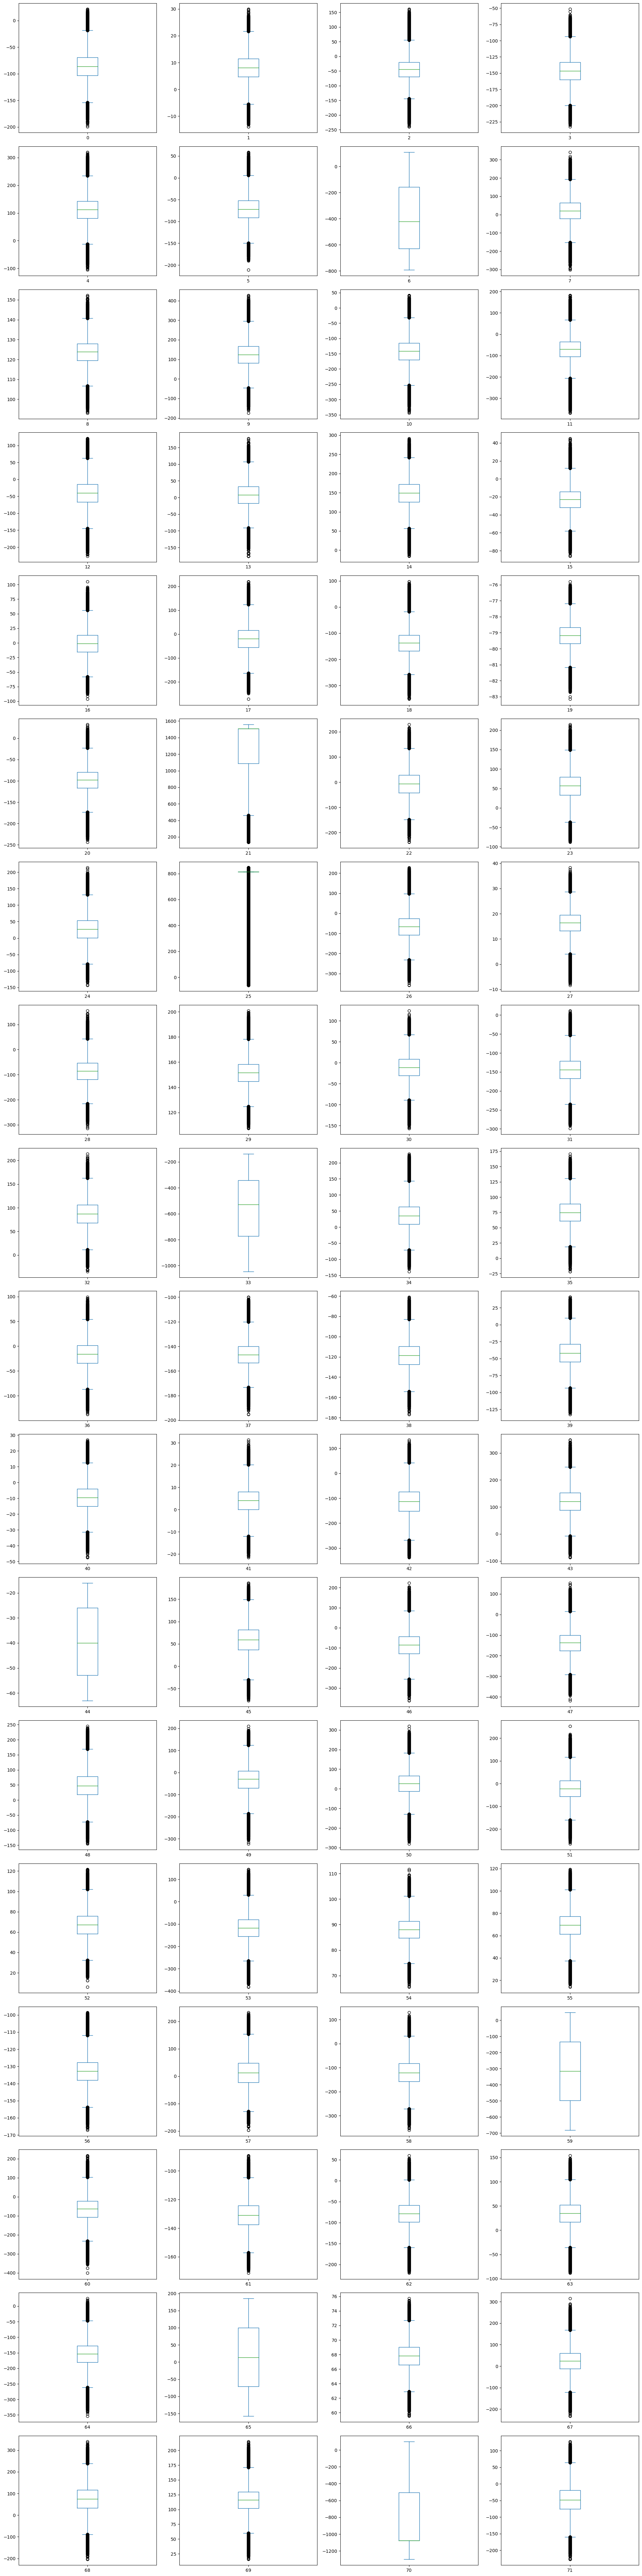

____________________________________________________________
График корреляции признаков:
____________________________________________________________
График корреляции признаков:


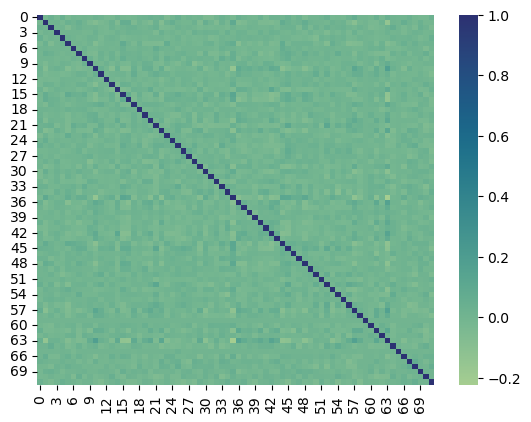

____________________________________________________________


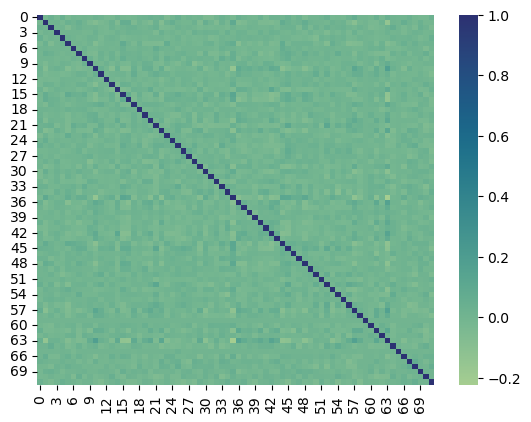

____________________________________________________________


In [13]:
eda(df_base)

Информация о датафрейме
____________________________________________________________
Размерность датафрейма: (100000, 73)
____________________________________________________________
Типы данных датафрейма:
Информация о датафрейме
____________________________________________________________
Размерность датафрейма: (100000, 73)
____________________________________________________________
Типы данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      

0              1              2              3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -85.328679       7.664345     -43.667046    -146.118630   
std        25.803845       4.955651      39.111064      20.434841   
min      -186.280270     -11.560507    -224.896060    -223.307220   
25%      -103.309147       4.313784     -69.494487    -160.028520   
50%       -85.273695       7.652854     -42.830246    -146.067445   
75%       -67.330810      10.981191     -17.713690    -132.277745   
max        14.585236      28.917845     128.108460     -60.751625   

                   4              5              6              7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      111.770592     -73.178792    -440.615118      21.231588   
std        47.700958      28.718853     279.017550      65.985214   
min       -93.272020    -184.962450    -791.469482    -278.582820   
25%        79.474322     -92.834080    -738.536868     -22.131764   
50%       112.260100     -73.364420    -511.837758      22.278989   
75%       143.760830     -53.699612    -201.116578      65.899595   
max       301.363600      51.849710     109.625188     288.171840   

                   8              9             10             11  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      123.067891     126.120201    -141.168584     -69.228444   
std         6.492081      64.912752      41.607785      51.258647   
min        94.831150    -142.156950    -330.570600    -352.405200   
25%       118.674642      82.545028    -168.599020    -103.048815   
50%       123.087540     125.963340    -140.461440     -68.753325   
75%       127.541802     169.701005    -113.136535     -34.668559   
max       149.356200     392.827150      37.017212     152.500000   

                  12             13             14             15  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -42.559541       6.506719     149.077582     -23.942253   
std        40.819544      37.593800      34.167843      13.024184   
min      -214.742460    -145.860280       8.818390     -82.645004   
25%       -69.801705     -18.815189     126.369124     -32.379752   
50%       -41.919796       6.739488     149.705675     -23.707227   
75%       -14.631057      32.074534     172.627318     -15.438074   
max       116.210100     171.126970     279.152560      35.552612   

                  16             17             18             19  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -2.219093     -12.964439    -138.714610     -79.159795   
std        20.978943      55.210920      48.737245       0.775560   
min       -91.657020    -247.589280    -326.648740     -82.637184   
25%       -16.455603     -49.612492    -171.661355     -79.656816   
50%        -2.339008     -12.189709    -139.009150     -79.137460   
75%        11.702535      24.464662    -106.746862     -78.638890   
max        94.324580     215.488050      79.245160     -75.835640   

                  20             21             22             23  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -97.474574    1297.269578      -3.600685      55.908014   
std        28.382144     375.123794      50.063680      35.617513   
min      -228.808260     136.873137    -211.971800     -87.323780   
25%      -115.407545    1248.126198     -37.047511      31.436791   
50%       -96.862695    1507.231274      -3.608930      55.273705   
75%       -78.583615    1507.231274      29.473402      79.557540   
max        26.484070    1557.383334     193.884310     207.021060   

                  24             25             26             27  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       23.470181     742.788817     -64.970553      16.368072   
std        40.802653     191.052074      63.160650       4.828575   
min      -1

0              1              2              3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -85.328679       7.664345     -43.667046    -146.118630   
std        25.803845       4.955651      39.111064      20.434841   
min      -186.280270     -11.560507    -224.896060    -223.307220   
25%      -103.309147       4.313784     -69.494487    -160.028520   
50%       -85.273695       7.652854     -42.830246    -146.067445   
75%       -67.330810      10.981191     -17.713690    -132.277745   
max        14.585236      28.917845     128.108460     -60.751625   

                   4              5              6              7  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      111.770592     -73.178792    -440.615118      21.231588   
std        47.700958      28.718853     279.017550      65.985214   
min       -93.272020    -184.962450    -791.469482    -278.582820   
25%        79.474322     -92.834080    -738.536868     -22.131764   
50%       112.260100     -73.364420    -511.837758      22.278989   
75%       143.760830     -53.699612    -201.116578      65.899595   
max       301.363600      51.849710     109.625188     288.171840   

                   8              9             10             11  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      123.067891     126.120201    -141.168584     -69.228444   
std         6.492081      64.912752      41.607785      51.258647   
min        94.831150    -142.156950    -330.570600    -352.405200   
25%       118.674642      82.545028    -168.599020    -103.048815   
50%       123.087540     125.963340    -140.461440     -68.753325   
75%       127.541802     169.701005    -113.136535     -34.668559   
max       149.356200     392.827150      37.017212     152.500000   

                  12             13             14             15  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -42.559541       6.506719     149.077582     -23.942253   
std        40.819544      37.593800      34.167843      13.024184   
min      -214.742460    -145.860280       8.818390     -82.645004   
25%       -69.801705     -18.815189     126.369124     -32.379752   
50%       -41.919796       6.739488     149.705675     -23.707227   
75%       -14.631057      32.074534     172.627318     -15.438074   
max       116.210100     171.126970     279.152560      35.552612   

                  16             17             18             19  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -2.219093     -12.964439    -138.714610     -79.159795   
std        20.978943      55.210920      48.737245       0.775560   
min       -91.657020    -247.589280    -326.648740     -82.637184   
25%       -16.455603     -49.612492    -171.661355     -79.656816   
50%        -2.339008     -12.189709    -139.009150     -79.137460   
75%        11.702535      24.464662    -106.746862     -78.638890   
max        94.324580     215.488050      79.245160     -75.835640   

                  20             21             22             23  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      -97.474574    1297.269578      -3.600685      55.908014   
std        28.382144     375.123794      50.063680      35.617513   
min      -228.808260     136.873137    -211.971800     -87.323780   
25%      -115.407545    1248.126198     -37.047511      31.436791   
50%       -96.862695    1507.231274      -3.608930      55.273705   
75%       -78.583615    1507.231274      29.473402      79.557540   
max        26.484070    1557.383334     193.884310     207.021060   

                  24             25             26             27  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       23.470181     742.788817     -64.970553      16.368072   
std        40.802653     191.052074      63.160650       4.828575   
min      -1

____________________________________________________________
Количество дубликатов в датафрейме:
____________________________________________________________
Количество дубликатов в датафрейме:
0
____________________________________________________________
Количество пропусков в датафрейме:
0
____________________________________________________________
Гистограммы распределения по признакам:
0
____________________________________________________________
Количество пропусков в датафрейме:
0
____________________________________________________________
Гистограммы распределения по признакам:


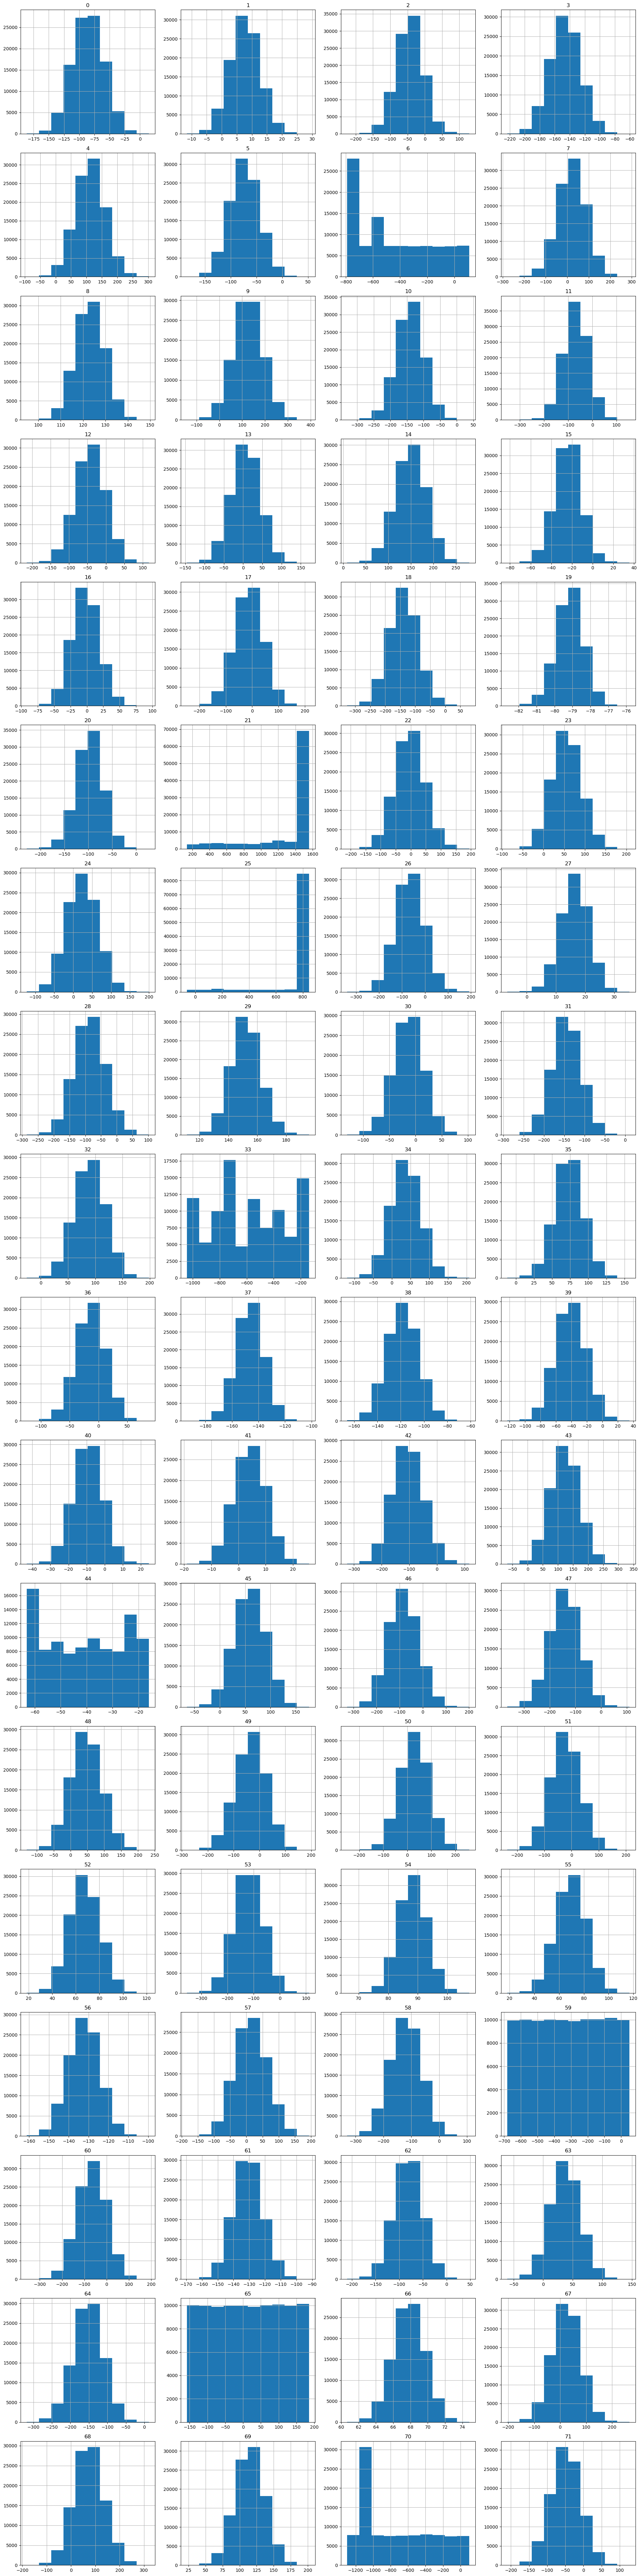

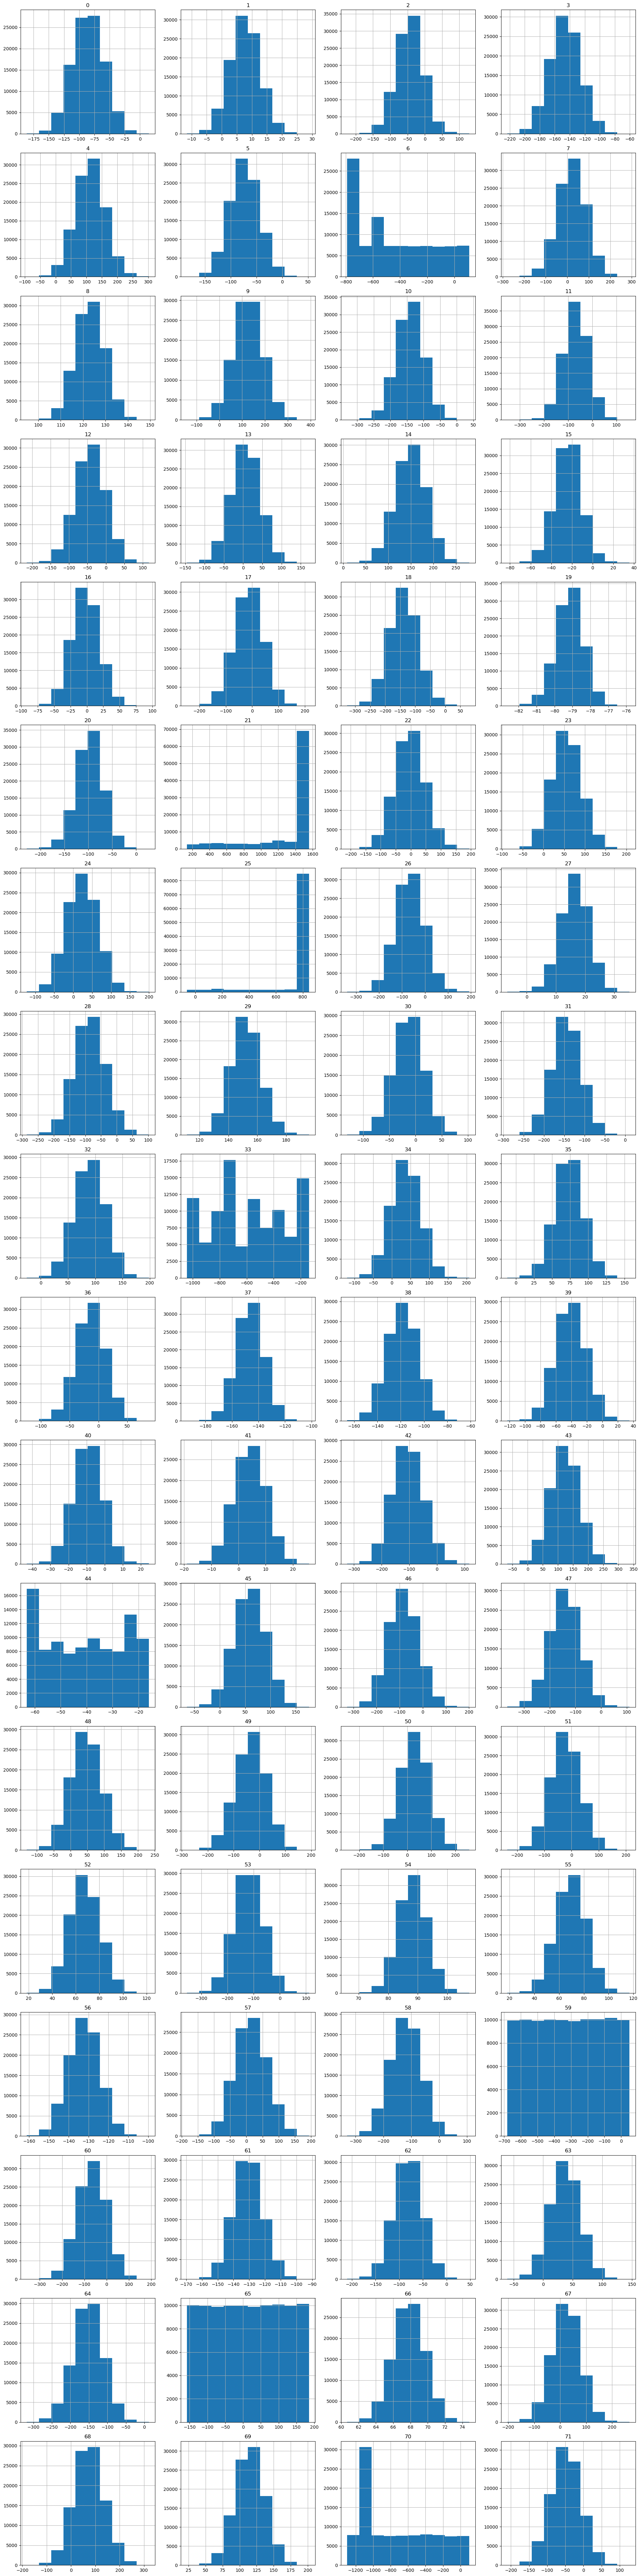

____________________________________________________________
Диаграммы размахов по признакам:
____________________________________________________________
Диаграммы размахов по признакам:


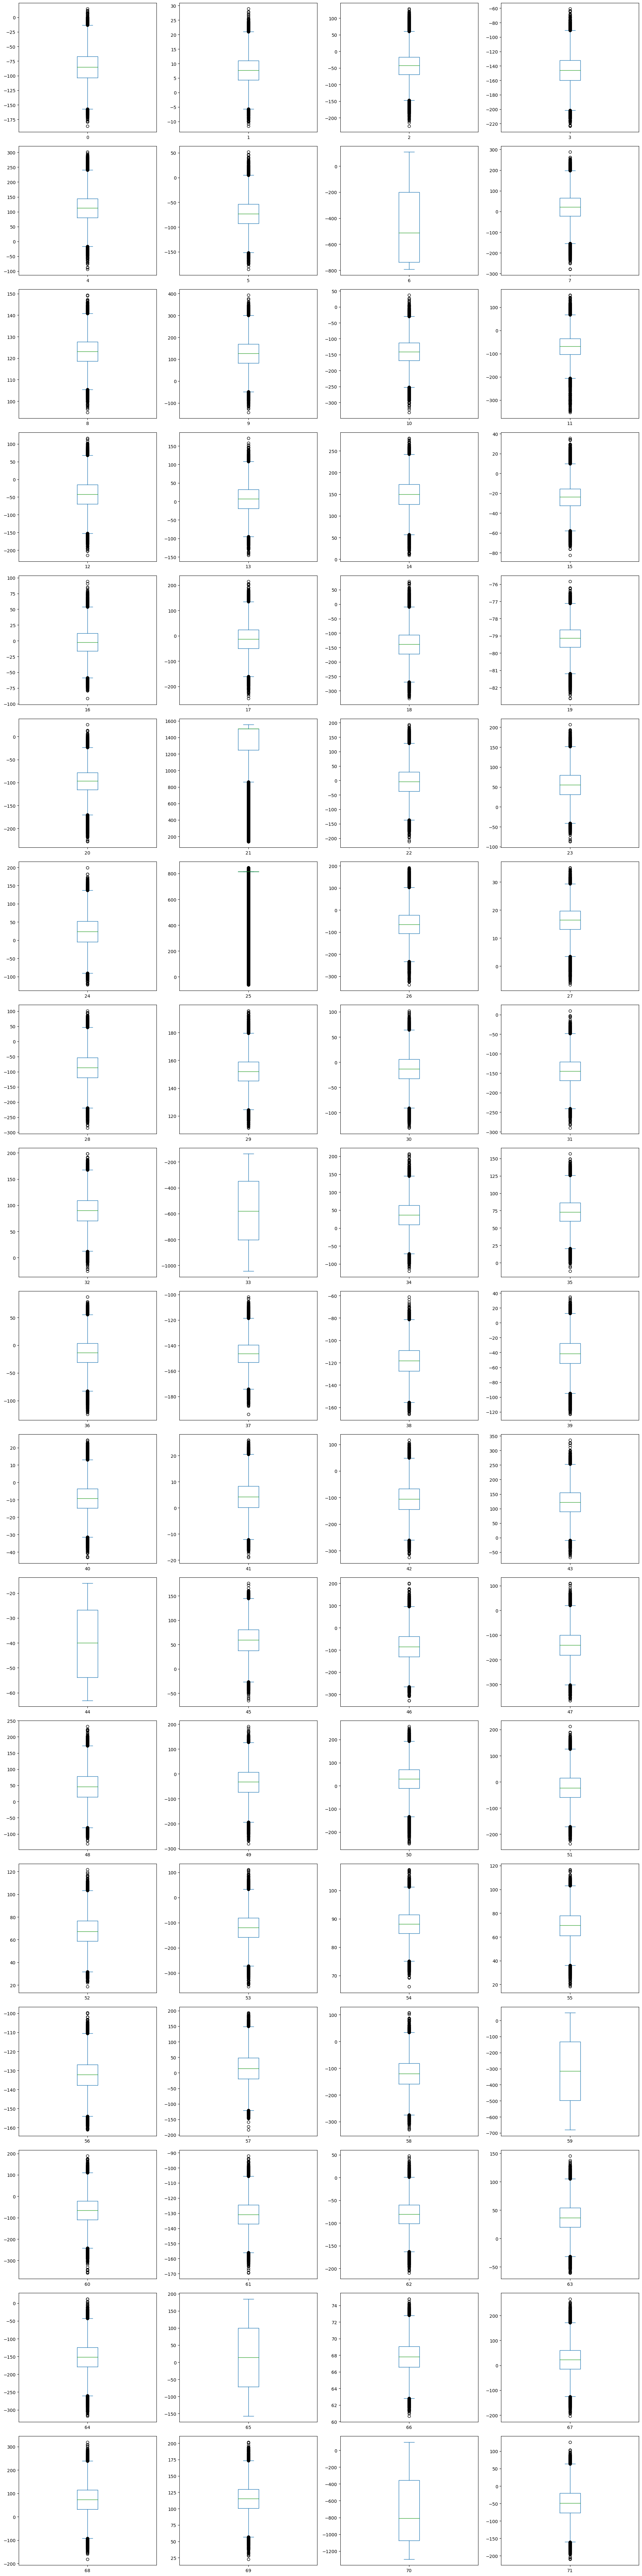

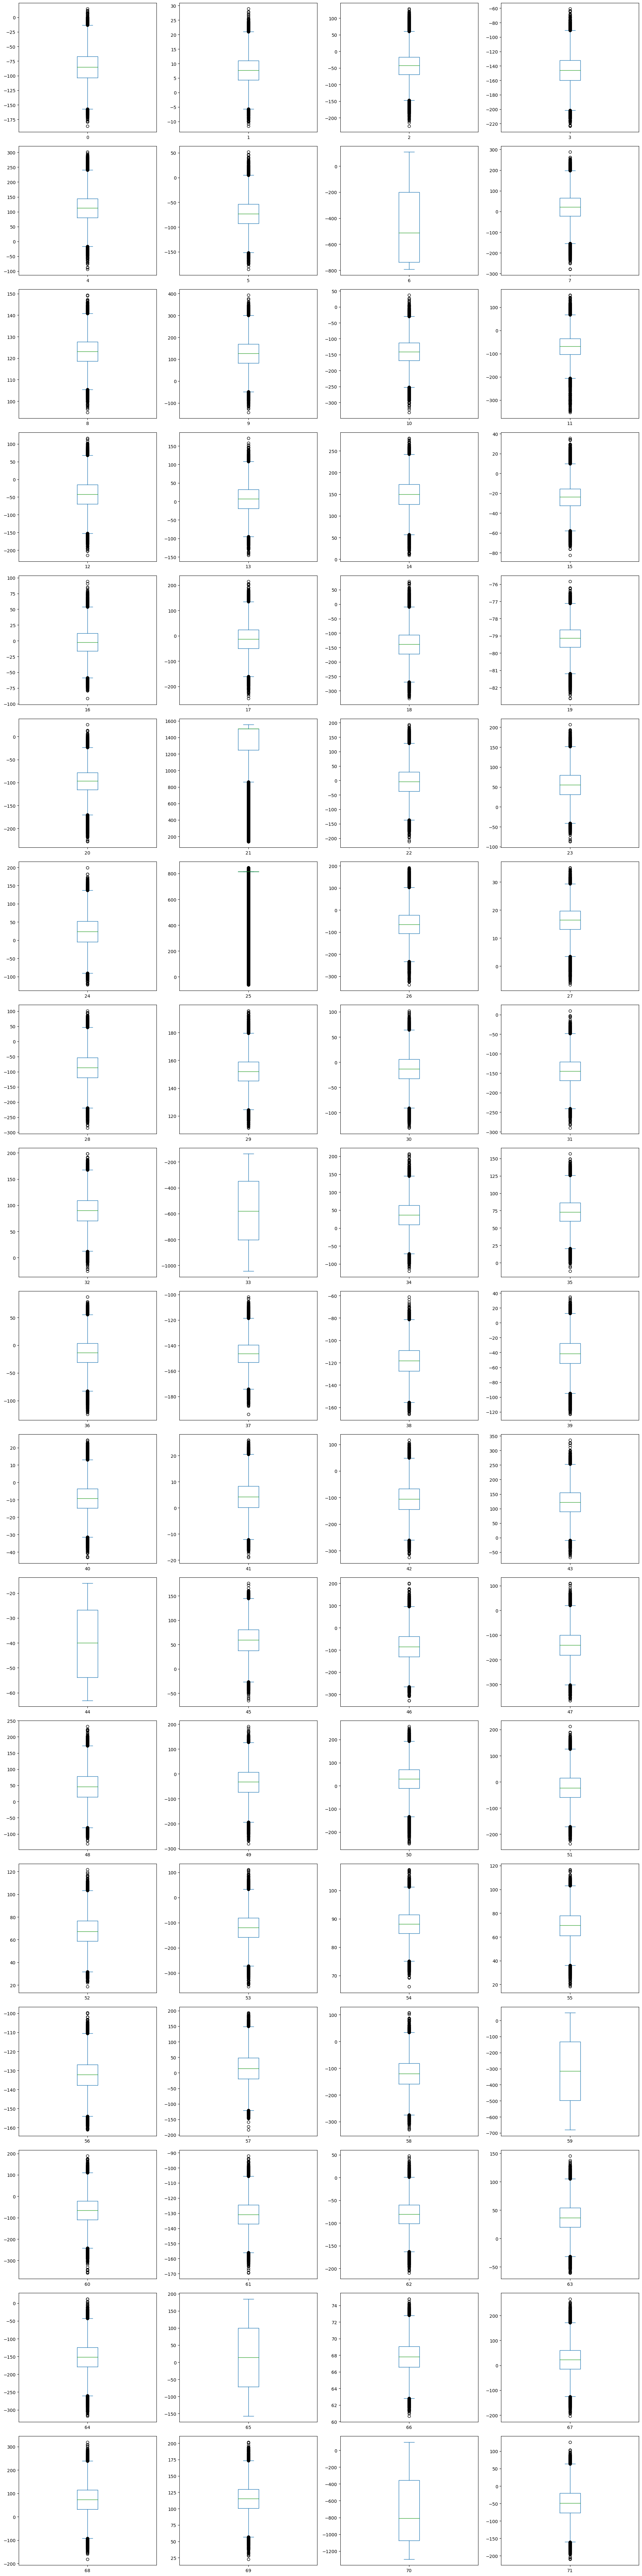

____________________________________________________________
График корреляции признаков:
____________________________________________________________
График корреляции признаков:


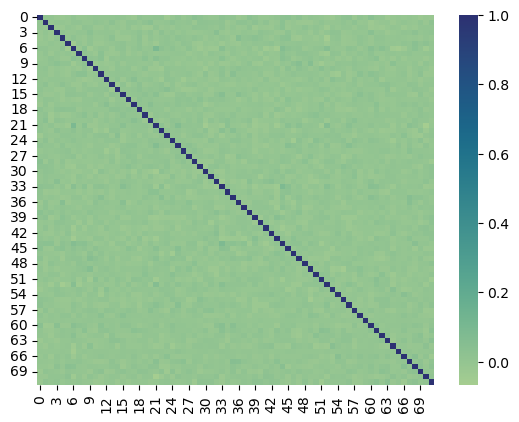

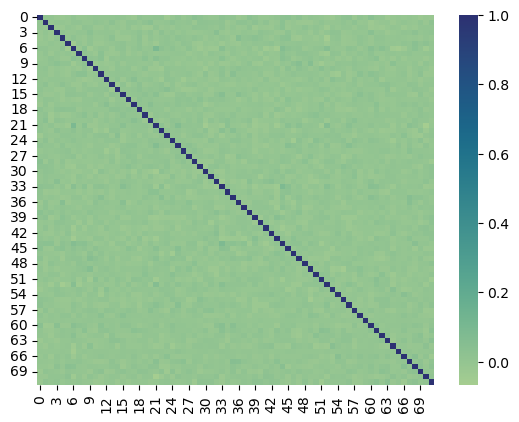

____________________________________________________________
____________________________________________________________


In [14]:
eda(df_train)

По результатам исследовательского анализа отмечаем, что признаки 6, 21, 25, 33, 44, 59, 65, 70 не имеют нормальное распределение. 

Разделим обучающую выборку на признаки и целевой признак.

In [15]:
target_train = df_train['Target']
df_train = df_train.drop('Target', axis=1)

## Сравнение базовых моделей и предобработка

В качестве базовых моделей используем различные механизмы мэтчинга FAISS.

Исходя из многомерности данных и их размера, для индексации в FAISS используем два механизма определения индекса: IVF Flat и IVF HNSW Flat (https://www.pinecone.io/learn/series/faiss/composite-indexes/).

Оптимальный выбор метрики, исходя из многомерности векторов и их количества - расстояние Махаланобиса (https://gist.github.com/mdouze/6cc12fa967e5d9911580ef633e559476).

Преобразование векторов в массивы - либо через PCA (https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization), либо через ascontiguousarray.

Создадим функцию для вычисления accuracy@k, которая будет принимать на вход датафреймы base и обучающий/валидационный/тестовый, тип модели FAISS.

Для FAISS используем параметры: количество клеток Вороного (кластеры), механизм поиска, метрика расстояния, размер выборки для обучения, количество измерений для выхода на преобразовании PCA, количество кластеров, по которым будет производиться поиск.


In [16]:
def faiss_accuracy(base, train, target,
                 model_type = 'faiss',
                 faiss_n_clusters = None,
                 faiss_idx = 'ivf_flat',
                 faiss_metric = 'mahalanobis',
                 faiss_train_sample_size = None,
                 faiss_pca_dims = None,
                 faiss_clusters_search = 32,
                 k_similar = K):
        
    dims = base.shape[1]
    
    base_index = {k: v for k, v in enumerate(base.index.to_list())}
        
    if 'faiss' in model_type:
            
        # Предусмотрим возможность либо снижения многомерности,
        # либо создания массивов ascontiguousarray
        
        if faiss_pca_dims:
            pca_matrix = faiss.PCAMatrix(dims, faiss_pca_dims)
            pca_matrix.train(base)
            assert pca_matrix.is_trained
            base_array = pca_matrix.apply(base)
            train_array = pca_matrix.apply(train)
            dims = faiss_pca_dims
        else:
            base_array = np.ascontiguousarray(base.values).astype('float32')
            train_array = np.ascontiguousarray(train.values).astype('float32')
        
        # механизм определения индексов IVF Flat
        if faiss_idx=='ivf_flat':
            quantizer = faiss.IndexFlatL2(dims)
            #интегрируем расстояние Махаланобиса в IVFFlat
            if faiss_metric == 'mahalanobis':
                #создаём матрицу ковариантности
                base_cov = base_array - base_array.mean(0)
                cov = np.dot(base_cov.T, base_cov) / base_cov.shape[0]
                #направляем векторы обратно в пространство с нормальным распределением
                L = np.linalg.cholesky(cov)
                mahalanobis_transform = np.linalg.inv(L)
                base_array = np.dot(base_array, mahalanobis_transform.T)
                base_array = base_array.astype('float32')
                train_array = np.dot(train_array, mahalanobis_transform.T)
                train_array = train_array.astype('float32')
                #определяем индекс
            faiss_idx = faiss.IndexIVFFlat(quantizer,
                                            dims,
                                            faiss_n_clusters)
            faiss_idx.nprobe = 10
        
        # механизм определения индексов IVF HNSW        
        elif faiss_idx=='ivf_hnsw':
            
            #воспользуемся index_factory для определения индексов в HNSW
            faiss_idx = faiss.index_factory(dims,
                                              (f'IVF{faiss_n_clusters}_HNSW'+
                                               f'{faiss_clusters_search}'+',Flat'))
            faiss_idx.nprobe = 10
        
        # добавим таймер
        start = perf_counter()

        faiss_idx.train(base_array[:faiss_train_sample_size, :])
        faiss_idx.add(base_array)
        
        r, idx = faiss_idx.search(train_array, k_similar)
        
        accuracy_faiss = 0
        for target, el in zip(target_train.values.tolist(), idx.tolist()):
            accuracy_faiss += int(target in [base_index[r] for r in el])
        
        time = perf_counter() - start
        
    return (round((100 * accuracy_faiss / len(idx)), 3),
                     round(time, 3))

Проводим сравнительный анализ метрик моделей для проверки гипотез.

### Гипотеза 1(а).

Наивысшая метрика accuracy@5 будет достигнута, если мы используем данные base и train без предобработки.

In [17]:
(accuracy_faiss_IVFFlat_1a, time_faiss_IVFFlat_1a) = faiss_accuracy(
    base=df_base, train=df_train, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_flat',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

In [18]:
(accuracy_faiss_IVFHNSW_1a, time_faiss_IVFHNSW_1a) = faiss_accuracy(
    base=df_base, train=df_train, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_hnsw',
    faiss_metric=None,
    faiss_train_sample_size=int(df_base.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

### Гипотеза 1(b).

Наивысшая метрика accuracy@5 будет достигнута, если мы используем данные без признаков 6, 21, 25, 33, 44, 59, 65, 70.

In [19]:
df_base_short = df_base.drop(['6','21','25','33','44','59','65','70'], axis=1)
df_train_short = df_train.drop(['6','21','25','33','44','59','65','70'], axis=1)

In [20]:
(accuracy_faiss_IVFFlat_1b, time_faiss_IVFFlat_1b) = faiss_accuracy(
    base=df_base_short, train=df_train_short, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_flat',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_short.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

In [21]:
(accuracy_faiss_IVFHNSW_1b, time_faiss_IVFHNSW_1b) = faiss_accuracy(
    base=df_base_short, train=df_train_short, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_hnsw',
    faiss_metric=None,
    faiss_train_sample_size=int(df_base_short.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

### Гипотеза 1(c).

Наивысшая метрика accuracy@5 будет достигнута, если мы используем данные без признаков, которые распределены ненормально по оценке теста Шапиро-Уилка.

In [22]:
def no_gaussian (df):
    print('Проверка признаков на нормальное распределение:')
    print('Нулевая гипотеза - распределение признака нормальное (значение p больше 0.05).')
    no_gaussian_list = []
    for column in df:
        statistic, pvalue = shapiro(df[column])
        print('Признак', df[column].name, ':')
        print('Статистика: %.3f, p: %.3f' % (statistic, pvalue))
        if pvalue > 0.05:
            print('Вероятно, распределение признака нормальное.\n')
        else:
            print('Вероятно, распределение признака ненормальное.\n')
            no_gaussian_list.append(df[column].name)
    print('Список признаков с вероятно ненормальным распределением:\n')
    print(no_gaussian_list)
    return(no_gaussian_list)


In [23]:
no_gaussian_list = no_gaussian(df_base)

Проверка признаков на нормальное распределение:
Нулевая гипотеза - распределение признака нормальное (значение p больше 0.05).
Проверка признаков на нормальное распределение:
Нулевая гипотеза - распределение признака нормальное (значение p больше 0.05).
Признак 0 :
Статистика: 1.002, p: 1.000
Вероятно, распределение признака нормальное.

Признак 0 :
Статистика: 1.002, p: 1.000
Вероятно, распределение признака нормальное.

Признак 1 :
Статистика: 1.001, p: 1.000
Вероятно, распределение признака нормальное.

Признак 1 :
Статистика: 1.001, p: 1.000
Вероятно, распределение признака нормальное.

Признак 2 :
Статистика: 0.998, p: 0.000
Вероятно, распределение признака ненормальное.

Признак 2 :
Статистика: 0.998, p: 0.000
Вероятно, распределение признака ненормальное.

Признак 3 :
Статистика: 1.002, p: 1.000
Вероятно, распределение признака нормальное.

Признак 3 :
Статистика: 1.002, p: 1.000
Вероятно, распределение признака нормальное.

Признак 4 :
Статистика: 1.002, p: 1.000
Вероятно, расп

In [24]:
df_base_very_short = df_base.drop(no_gaussian_list, axis=1)
df_train_very_short = df_train.drop(no_gaussian_list, axis=1)

In [25]:
(accuracy_faiss_IVFFlat_1c, time_faiss_IVFFlat_1c) = faiss_accuracy(
    base=df_base_very_short, train=df_train_very_short, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_flat',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_very_short.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)


In [26]:
(accuracy_faiss_IVFHNSW_1c, time_faiss_IVFHNSW_1c) = faiss_accuracy(
    base=df_base_very_short, train=df_train_very_short, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_hnsw',
    faiss_metric=None,
    faiss_train_sample_size=int(df_base_very_short.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)


In [27]:
hyp_1_ivfflat_acc = [accuracy_faiss_IVFFlat_1a,
                     accuracy_faiss_IVFFlat_1b,
                     accuracy_faiss_IVFFlat_1c]
hyp_1_ivfflat_time = [time_faiss_IVFFlat_1a,
                       time_faiss_IVFFlat_1b,
                       time_faiss_IVFFlat_1c]
hyp_1_ivfflat_df = pd.DataFrame(data=[hyp_1_ivfflat_acc,
                                       hyp_1_ivfflat_time],
                                columns=['Все признаки',
                                         'Без признаков 6, 21, 25, 33, 44, 59, 65, 70',
                                         'Без ненормального распределения по Шапиро'],
                                index=['accuracy@5', 'Время поиска, с'])


In [28]:
hyp_1_ivfhnsw_acc = [accuracy_faiss_IVFHNSW_1a,
                     accuracy_faiss_IVFHNSW_1b,
                     accuracy_faiss_IVFHNSW_1c]
hyp_1_ivfhnsw_time = [time_faiss_IVFHNSW_1a,
                       time_faiss_IVFHNSW_1b,
                       time_faiss_IVFHNSW_1c]
hyp_1_ivfhnsw_df = pd.DataFrame(data=[hyp_1_ivfhnsw_acc,
                                       hyp_1_ivfhnsw_time],
                                columns=['Все признаки',
                                         'Без признаков 6, 21, 25, 33, 44, 59, 65, 70',
                                         'Без ненормального распределения по Шапиро'],
                                index=['accuracy@5', 'Время поиска, с'])


In [29]:
print('Результаты проверки первого блока гипотез на IVF Flat')
display(hyp_1_ivfflat_df)
print('Результаты проверки первого блока гипотез на IVF HNSW')
display(hyp_1_ivfhnsw_df)

Результаты проверки первого блока гипотез на IVF Flat


Все признаки  Без признаков 6, 21, 25, 33, 44, 59, 65, 70  \
accuracy@5             64.713                                       70.433   
Время поиска, с       391.754                                      337.295   

                 Без ненормального распределения по Шапиро  
accuracy@5                                          69.187  
Время поиска, с                                    178.232

Результаты проверки первого блока гипотез на IVF Flat
Результаты проверки первого блока гипотез на IVF HNSW


Все признаки  Без признаков 6, 21, 25, 33, 44, 59, 65, 70  \
accuracy@5             64.713                                       70.433   
Время поиска, с       391.754                                      337.295   

                 Без ненормального распределения по Шапиро  
accuracy@5                                          69.187  
Время поиска, с                                    178.232

Все признаки  Без признаков 6, 21, 25, 33, 44, 59, 65, 70  \
accuracy@5             13.673                                       68.868   
Время поиска, с       339.261                                      304.345   

                 Без ненормального распределения по Шапиро  
accuracy@5                                          66.217  
Время поиска, с                                    183.947

Результаты проверки первого блока гипотез на IVF HNSW


Все признаки  Без признаков 6, 21, 25, 33, 44, 59, 65, 70  \
accuracy@5             13.673                                       68.868   
Время поиска, с       339.261                                      304.345   

                 Без ненормального распределения по Шапиро  
accuracy@5                                          66.217  
Время поиска, с                                    183.947

Промежуточный итог: наибольший accuracy@5 демонстрирует модель FAISS на датафрейме без признаков, в отношении которых мы сделали вывод о ненормальном распределении на основании гистограмм. Наилучшую метрику accuracy@5 на гиперпараметрах по умолчанию показывант IVF Flat. Подтверждается нулевая гипотеза 1(b).

In [30]:
del df_base
del df_train
del df_base_very_short
del df_train_very_short

### Гипотеза 2(а).

Наивысшая метрика accuracy@5 будет достигнута, если мы проведём масштабирование данных с помощью StandardScaler.

In [31]:
df_base = pd.read_csv('/Users/nikitagoroshevskiy/desktop/projects/data/base.csv', index_col=0)
df_train = pd.read_csv('/Users/nikitagoroshevskiy/desktop/projects/data/train.csv', index_col=0)
df_train = df_train.drop('Target', axis=1)

In [32]:
df_base_short = df_base.drop(['6','21','25','33','44','59','65','70'], axis=1)
df_train_short = df_train.drop(['6','21','25','33','44','59','65','70'], axis=1)

In [33]:
scaler = StandardScaler()
df_base_short_ss = pd.DataFrame(scaler.fit_transform(df_base_short),
                         columns=df_base_short.columns,
                         index=df_base_short.index)
df_train_short_ss = pd.DataFrame(scaler.transform(df_train_short),
                         columns=df_train_short.columns,
                         index=df_train_short.index)

In [34]:
(accuracy_faiss_IVFFlat_2a, time_faiss_IVFFlat_2a) = faiss_accuracy(
    base=df_base_short_ss, train=df_train_short_ss, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_flat',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_short_ss.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

In [35]:
(accuracy_faiss_IVFHNSW_2a, time_faiss_IVFHNSW_2a) = faiss_accuracy(
    base=df_base_short_ss, train=df_train_short_ss, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_hnsw',
    faiss_metric=None,
    faiss_train_sample_size=int(df_base_short_ss.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

### Гипотеза 2(b).

Наивысшая метрика accuracy@5 будет достигнута, если мы проведём масштабирование данных с помощью RobustScaler.

In [36]:
scaler = RobustScaler()
df_base_short_rs = pd.DataFrame(scaler.fit_transform(df_base_short),
                         columns=df_base_short.columns,
                         index=df_base_short.index)
df_train_short_rs = pd.DataFrame(scaler.transform(df_train_short),
                         columns=df_train_short.columns,
                         index=df_train_short.index)

In [37]:
(accuracy_faiss_IVFFlat_2b, time_faiss_IVFFlat_2b) = faiss_accuracy(
    base=df_base_short_rs, train=df_train_short_rs, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_flat',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_short_rs.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

In [38]:
(accuracy_faiss_IVFHNSW_2b, time_faiss_IVFHNSW_2b) = faiss_accuracy(
    base=df_base_short_rs, train=df_train_short_rs, target=target_train,
    model_type='faiss',
    faiss_n_clusters=100,
    faiss_idx='ivf_hnsw',
    faiss_metric=None,
    faiss_train_sample_size=int(df_base_short_rs.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=10
)

In [39]:
hyp_2_ivfflat_acc = [accuracy_faiss_IVFFlat_2a,
                     accuracy_faiss_IVFFlat_2b]
hyp_2_ivfflat_time = [time_faiss_IVFFlat_2a,
                       time_faiss_IVFFlat_2b]
hyp_2_ivfflat_df = pd.DataFrame(data=[hyp_2_ivfflat_acc,
                                       hyp_2_ivfflat_time],
                                columns=['StandardScaler',
                                         'RobustScaler'],
                                index=['accuracy@5', 'Время поиска, с'])



In [40]:
hyp_2_ivfhnsw_acc = [accuracy_faiss_IVFHNSW_2a,
                     accuracy_faiss_IVFHNSW_2b]
hyp_2_ivfhnsw_time = [time_faiss_IVFHNSW_2a,
                       time_faiss_IVFHNSW_2b]
hyp_2_ivfhnsw_df = pd.DataFrame(data=[hyp_2_ivfhnsw_acc,
                                       hyp_2_ivfhnsw_time],
                                columns=['StandardScaler',
                                         'RobustScaler'],
                                index=['accuracy@5', 'Время поиска, с'])



In [41]:
print('Результаты проверки второго блока гипотез на IVF Flat')
display(hyp_2_ivfflat_df)
print('Результаты проверки второго блока гипотез на IVF HNSW')
display(hyp_2_ivfhnsw_df)

Результаты проверки второго блока гипотез на IVF Flat
Результаты проверки второго блока гипотез на IVF Flat


StandardScaler  RobustScaler
accuracy@5               70.451        70.460
Время поиска, с         351.430       340.238

StandardScaler  RobustScaler
accuracy@5               70.451        70.460
Время поиска, с         351.430       340.238

Результаты проверки второго блока гипотез на IVF HNSW
Результаты проверки второго блока гипотез на IVF HNSW


StandardScaler  RobustScaler
accuracy@5               70.184        70.161
Время поиска, с         453.465       410.343

StandardScaler  RobustScaler
accuracy@5               70.184        70.161
Время поиска, с         453.465       410.343

Модели на базе IVF Flat и HNSW демонстрируют весьма близие метрики accuracy@5, при этом IVF Flat осуществляет поиск быстрее. Наивысшая метрика достигается при масштабировании RobustScaler - подтверждается нулевая гипотеза 2(b).

## Настройка гиперпараметров моделей

### Оптимальное количество кластеров

По наименьшему коэффициенту Дэвиса-Боулдина через инструмент MiniBatchKMeans найдём оптимальное количество кластеров для FAISS.

In [42]:
def mb_k_means_db(df: pd.DataFrame(), 
                         n_clusters: list, 
                         seed = SEED):

    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]

    print('Коэффициент схожести кластеров Дэвиса-Боулдина:')
    
    for n in tqdm(n_clusters):
        
        cluster_k = MiniBatchKMeans(n_clusters=n, 
                                    init='k-means++', 
                                    n_init='auto', 
                                    batch_size=1536, 
                                    random_state=seed).fit(df)
        
        db_score = davies_bouldin_score(df, cluster_k.labels_)
        print(f'{n} кластеров: {round(db_score, 3)}.\n-----')

In [43]:
%%time
mb_k_means_db(df=df_base_short_rs,
              n_clusters=[10, 20, 50, 100, 200, 300])

Коэффициент схожести кластеров Дэвиса-Боулдина:
Коэффициент схожести кластеров Дэвиса-Боулдина:


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

10 кластеров: 5.104.
-----
10 кластеров: 5.104.
-----
20 кластеров: 4.149.
-----
20 кластеров: 4.149.
-----
50 кластеров: 3.275.
-----
50 кластеров: 3.275.
-----
100 кластеров: 3.029.
-----
100 кластеров: 3.029.
-----
200 кластеров: 2.908.
-----
200 кластеров: 2.908.
-----
300 кластеров: 2.923.
-----
CPU times: user 2min 58s, sys: 20.8 s, total: 3min 19s
Wall time: 1min 4s
300 кластеров: 2.923.
-----
CPU times: user 2min 58s, sys: 20.8 s, total: 3min 19s
Wall time: 1min 4s


Минимальный индекс Дэвиса-Боулдина достигается на 200 кластерах.

### PCA

Проверим целесообразность использования PCA на сокращении признаков на 50 процентов.

In [44]:
accuracy_faiss_IVFFlat_pca, time_faiss_IVFFlat_pca = faiss_accuracy(
    base=df_base_short_rs, train=df_train_short_rs, target=target_train,
    model_type='faiss',
    faiss_n_clusters=200,
    faiss_idx='ivf_flat',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_short_rs.shape[0] * 0.15),
    faiss_pca_dims=33,
    faiss_clusters_search=10
)

In [45]:
accuracy_faiss_IVFHNSW_pca, time_faiss_IVFHNSW_pca = faiss_accuracy(
    base=df_base_short_rs, train=df_train_short_rs, target=target_train,
    model_type='faiss',
    faiss_n_clusters=200,
    faiss_idx='ivf_hnsw',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_short_rs.shape[0] * 0.15),
    faiss_pca_dims=33,
    faiss_clusters_search=10
)

In [46]:
hyp_pca_ivfflat_df = pd.DataFrame(data=[accuracy_faiss_IVFFlat_pca,
                                       time_faiss_IVFFlat_pca],
                                  columns=['PCA'],
                                  index=['accuracy@5', 'Время поиска, с'])

In [47]:
hyp_pca_ivfhnsw_df = pd.DataFrame(data=[accuracy_faiss_IVFHNSW_pca,
                                       time_faiss_IVFHNSW_pca],
                                  columns=['PCA'],
                                  index=['accuracy@5', 'Время поиска, с'])

In [48]:
print('Результаты проверки PCA на IVF Flat')
display(hyp_pca_ivfflat_df)


Результаты проверки PCA на IVF Flat


PCA
accuracy@5       67.503
Время поиска, с  66.060

Результаты проверки PCA на IVF Flat


PCA
accuracy@5       67.503
Время поиска, с  66.060

In [49]:
print('Результаты проверки PCA на IVF HNSW')
display(hyp_pca_ivfhnsw_df)

Результаты проверки PCA на IVF HNSW
Результаты проверки PCA на IVF HNSW


PCA
accuracy@5       67.243
Время поиска, с  68.611

PCA
accuracy@5       67.243
Время поиска, с  68.611

С применением PCA существенно сокращается время поиска, однако accuracy@5 также существенно снижается.

### Размерность графа HNSW

Проверим изменения метрик IVF HNSW при изменении размера графа HNSW.

In [50]:
accuracy_list = []
time_list = []

for n in tqdm(range(20,120,20)):
    
    (accuracy_faiss_IVFHNSW, time_faiss_IVFHNSW) = faiss_accuracy(
    base=df_base_short_rs, train=df_train_short_rs, target=target_train,
    model_type='faiss',
    faiss_n_clusters=200,
    faiss_idx='ivf_hnsw',
    faiss_metric='mahalanobis',
    faiss_train_sample_size=int(df_base_short_rs.shape[0] * 0.15),
    faiss_pca_dims=None,
    faiss_clusters_search=n
    )
    accuracy_list.append(accuracy_faiss_IVFHNSW)
    time_list.append(time_faiss_IVFHNSW)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [51]:
ivfhnsw_df = pd.DataFrame(data=[accuracy_list,
                                time_list],
                          columns=['20','40','60', '80', '100'],
                          index=['accuracy@5', 'Время поиска, с'])
print('Результаты метрик при изменении размера графа HNSW')
display(ivfhnsw_df)

Результаты метрик при изменении размера графа HNSW


20       40       60       80      100
accuracy@5        69.217   70.099   70.211   70.219   70.221
Время поиска, с  151.439  150.822  149.034  148.264  148.024

Результаты метрик при изменении размера графа HNSW


20       40       60       80      100
accuracy@5        69.217   70.099   70.211   70.219   70.221
Время поиска, с  151.439  150.822  149.034  148.264  148.024

По результатам перебора гиперпараметров наилучшие метрики accuracy@5 и времени поиска показала модель FAISS IVF200_HNSW100 на датафрейме с удалёнными признаками с ненормальным распределением по гистограмме и с масштабированием с помощью RobustScaler.

## Проверка модели на тестовой выборке

Преобразуем тестовую выборку аналогично тренировочной - удаляем признаки с ненормальным распределением и масштабируем данные на RobustScaler.

In [60]:
df_validation = df_validation.drop(['6','21','25','33','44','59','65','70'], axis=1)
df_validation_short_rs = pd.DataFrame(scaler.transform(df_validation),
                         columns=df_validation.columns,
                         index=df_validation.index)


Тестируем модель FAISS IVF200_HNSW100, Flat.

In [62]:
dims = df_base_short_rs.shape[1]
base_index = {k: v for k, v in enumerate(df_base_short_rs.index.to_list())}
base_array = np.ascontiguousarray(df_base_short_rs.values).astype('float32')
train_array = np.ascontiguousarray(df_validation_short_rs.values).astype('float32')
faiss_idx = faiss.index_factory(dims, 'IVF200_HNSW100,Flat')
faiss_idx.nprobe = 10
start = perf_counter()

faiss_idx.train(base_array[:int(df_base_short_rs.shape[0] * 0.15), :])
faiss_idx.add(base_array)

r, idx = faiss_idx.search(train_array, 5)

acc = 0
for target, el in zip(df_validation_answer['Expected'].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
accuracy_faiss = 100 * acc / len(idx)
time_faiss = round((perf_counter() - start),2)

In [63]:
ivfhnsw_test = pd.DataFrame(data=[accuracy_faiss,
                                time_faiss],
                          columns=['IVF200_HNSW100'],
                          index=['accuracy@5', 'Время поиска, с'])
print('Результаты метрик IVF200_HNSW100 на тестовой выборке')
display(ivfhnsw_test)

Результаты метрик IVF200_HNSW100 на тестовой выборке


IVF200_HNSW100
accuracy@5               70.076
Время поиска, с         148.490

Результаты метрик IVF200_HNSW100 на тестовой выборке


IVF200_HNSW100
accuracy@5               70.076
Время поиска, с         148.490

## Результаты проекта

По итогам проекта была составлена оптимальная модель для мэтчинга товаров в заданных условиях и проведена его оценка по метрике accuracy@5. Используемая модель - FAISS IVF HNSW на 200 кластерах с размерностью графа 100 с удалением ненормально распределённых признаков на основании гистограмм и масштабированием RobustScaler.

Ограничения проекта: необходимо больше информации о смысловом содержимом признаков для более корректной предобработки.

Возможные направления развития: реализовать для поиска оптимальной модели библиотеки ANNOY и KNearestNeighbors.